In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

2025-03-09 15:29:25.498057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 15:29:25.506320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 15:29:25.602526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 15:29:25.675148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741514365.737807  156694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741514365.76

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

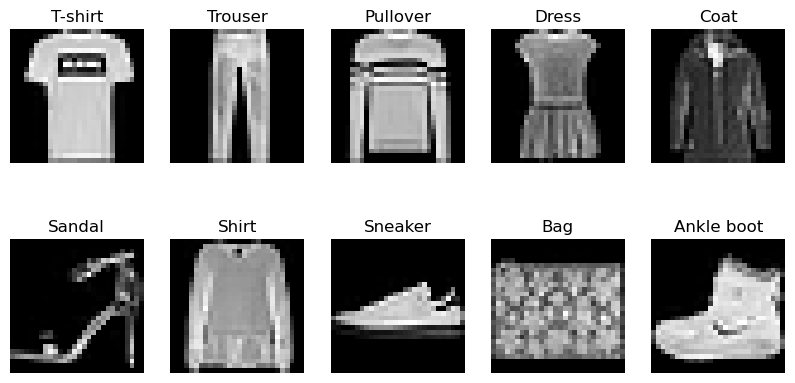

In [4]:
# Display one sample per class
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    sample_idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[sample_idx].reshape(28, 28), cmap="gray")
    ax.set_title(classes[i])
    ax.axis("off")
plt.show()


In [23]:
class NeuralNetwork:
    def __init__(self, layers, activation=None, output_activation = 'softmax', weight_init=None):
        """
        Initializes the neural network.
        :param layers: List representing the number of neurons in each layer.
        :param activation: Activation function for hidden layers ('relu', 'sigmoid', 'tanh').
        :param output_activation: Activation function for the output layer ('softmax', 'sigmoid', or 'linear').
        :param weight_init: Weight initialization method ('random', 'xavier').
        """
        self.layers = layers
        self.activation = activation
        self.output_activation = output_activation  # Separate activation for output layer
        self.weight_init = weight_init
        self.weights, self.biases = self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights and biases based on the selected method."""
        np.random.seed(42)
        weights, biases = [], []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
                w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            else:  # Default: Random small values
                w = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            
            b = np.zeros((1, self.layers[i+1]))
            weights.append(w)
            biases.append(b)
        
        return weights, biases

    def _activation(self, x, func, derivative=False):
        """Applies the selected activation function."""
        if func == "relu":
            return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)
        elif func == "tanh":
            t = np.tanh(x)
            return 1 - t**2 if derivative else t
        elif func == "sigmoid":
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig) if derivative else sig
        elif func == "softmax":
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:  # Linear (no activation)
            return x

    def forward(self, X):
        """Performs forward propagation."""
        activations, zs = [X], []

        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(activations[-1], w) + b
            zs.append(z)

            # Use different activation for last layer
            if i == len(self.weights) - 1:
                activations.append(self._activation(z, self.output_activation))
            else:
                activations.append(self._activation(z, self.activation))
        
        return activations, zs

    def backward(self, y_true, activations, zs, learning_rate):
        """Performs backpropagation and computes gradients."""
        grads_w, grads_b = [], []
        m = y_true.shape[0]
        
        # Compute loss gradient (assuming MSE loss for now)
        dA = activations[-1] - y_true  

        for i in reversed(range(len(self.weights))):
            activation_func = self.output_activation if i == len(self.weights) - 1 else self.activation
            dz = dA * self._activation(zs[i], activation_func, derivative=True)
            dw = np.dot(activations[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            dA = np.dot(dz, self.weights[i].T)

            grads_w.insert(0, dw)
            grads_b.insert(0, db)

        return grads_w, grads_b


Epoch 8: Train Loss=nan, Train Acc=0.1000, Val Loss=nan, Val Acc=0.1000

wandb: ERROR Problem finishing run
Exception in thread Thread-32 (_run_job):
Traceback (most recent call last):
  File "/home/tenet/anaconda3/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_156694/875204119.py", line 67, in train
  File "/home/tenet/anaconda3/lib/python3.11/site-packages/wandb/sdk/lib/redirect.py", line 645, in write
    self._old_write(data)
  File "/home/tenet/anaconda3/lib/python3.11/site-packages/ipykernel/iostream.py", line 662, in write
    self._schedule_flush()
  File "/home/tenet/anaconda3/lib/python3.11/site-packages/ipykernel/iostream.py", line 559, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/home/tenet/anaconda3/lib/python3.11/site-packages/ipykernel/iostream.py", line 266, in schedule
    self._event_pipe.send(b"")
  File "/home/tenet/anaconda3/lib/python3.11/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=fla

In [24]:
# Optimizers
class Optimizer:
    def __init__(self, method= None, lr=None, beta=0.9, beta2=0.999, epsilon=1e-8):
        self.method = method
        self.lr = lr
        self.beta = beta  # Used for momentum-based optimizers
        self.beta2 = beta2  # Used for RMSprop, Adam, Nadam
        self.epsilon = epsilon  # Prevents division by zero
        self.m_w = None  # First moment vector for weights
        self.v_w = None  # Second moment vector for weights
        self.m_b = None  # First moment vector for biases
        self.v_b = None  # Second moment vector for biases
        self.t = 0  # Time step for bias correction

    def update(self, weights, biases, grads_w, grads_b):
        if self.method == "sgd":
            weights = [w - self.lr * dw for w, dw in zip(weights, grads_w)]
            biases = [b - self.lr * db for b, db in zip(biases, grads_b)]

        elif self.method in ["momentum", "nesterov"]:
            if self.m_w is None:  # Initialize momentum terms
                self.m_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]

            for i in range(len(weights)):
                if self.method == "nesterov":
                    # Look-ahead step
                    look_ahead_w = weights[i] - self.beta * self.m_w[i]
                    look_ahead_b = biases[i] - self.beta * self.m_b[i]

                    # Compute gradients at look-ahead position
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]

                    weights[i] = look_ahead_w - self.m_w[i]
                    biases[i] = look_ahead_b - self.m_b[i]

                else:  # Normal momentum
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]
                    weights[i] -= self.m_w[i]
                    biases[i] -= self.m_b[i]

        elif self.method in ["rmsprop", "adam", "nadam"]:
            if self.m_w is None:  # Initialize moment estimates
                self.m_w = [np.zeros_like(w) for w in weights]
                self.v_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]
                self.v_b = [np.zeros_like(b) for b in biases]

            self.t += 1  # Update time step

            for i in range(len(weights)):
                if self.method == "rmsprop":
                    # Update second moment estimate (squared gradient)
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * grads_w[i] ** 2
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * grads_b[i] ** 2

                    # Update weights and biases
                    weights[i] -= self.lr * grads_w[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                    biases[i] -= self.lr * grads_b[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

                elif self.method in ["adam", "nadam"]:
                    # Compute biased first moment estimate
                    self.m_w[i] = self.beta * self.m_w[i] + (1 - self.beta) * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + (1 - self.beta) * grads_b[i]

                    # Compute biased second moment estimate
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)

                    # Bias correction
                    m_hat_w = self.m_w[i] / (1 - self.beta ** self.t)
                    v_hat_w = self.v_w[i] / (1 - self.beta2 ** self.t)
                    m_hat_b = self.m_b[i] / (1 - self.beta ** self.t)
                    v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)

                    if self.method == "adam":
                        # Adam update rule
                        weights[i] -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

                    elif self.method == "nadam":
                        # Nadam additional momentum correction
                        nadam_m_w = self.beta * m_hat_w + (1 - self.beta) * grads_w[i] / (1 - self.beta ** self.t)
                        nadam_m_b = self.beta * m_hat_b + (1 - self.beta) * grads_b[i] / (1 - self.beta ** self.t)

                        weights[i] -= self.lr * nadam_m_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * nadam_m_b / (np.sqrt(v_hat_b) + self.epsilon)

        return weights, biases

In [32]:
def train():
    wandb.init(project="Assignment1_Attempt3")
    config = wandb.config  # Get hyperparameters
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_e_{config.epochs}"
    print(run_name)
    wandb.run.name = run_name

    # Extract hyperparameters from WandB
    layers = [784] + [config.hidden_size] * config.hidden_layers + [10]
    activation = config.activation
    weight_init = config.weight_init
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    optimizer = config.optimizer
    epochs = config.epochs


    # Initialize Neural Network
    model = NeuralNetwork(layers, activation=activation, weight_init=weight_init)
    optimizer = Optimizer(method=optimizer, lr=learning_rate)

    for epoch in range(epochs):
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            # Forward propagation
            activations, zs = model.forward(X_batch)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            # Compute loss and accuracy
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            # Backpropagation
            grads_w, grads_b = model.backward(y_batch, activations, zs, learning_rate)
            model.weights, model.biases = optimizer.update(model.weights, model.biases, grads_w, grads_b)

        # Average loss and accuracy
        train_loss /= num_batches
        train_acc /= num_batches

        # Validation phase
        val_activations, _ = model.forward(X_test)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        val_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)
        val_acc = np.mean(val_preds == val_true_labels)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


In [33]:
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficiency
    'metric': {'name': 'val_loss', 'goal': 'minimize'},  # Optimize for lowest validation loss
    'parameters': {
        'epochs': {'values': [5, 10, 15, 20]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},  # <--- Added missing comma
        'epsilon': {'values': [0.8, 0.9, 0.95]}
    }
}


In [34]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_Attempt3")
wandb.agent(sweep_id, train, count=200)  # Run 200 different hyperparameter combinations

Create sweep with ID: 2eskfzbe
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/Assignment_Attempt3/sweeps/2eskfzbe


wandb: Agent Starting Run: f8qnzz7f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451
Epoch 6: Train Loss=0.0177, Train Acc=0.8741, Val Loss=0.0206, Val Acc=0.8546
Epoch 7: Train Loss=0.0174, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8524
Epoch 8: Train Loss=0.0172, Train Acc=0.8786, Val Loss=0.0212, Val Acc=0.8512
Epoch 9: Train Loss=0.0171, Train Acc=0.8784, Val Loss=0.0215, Val Acc=0.8512
Epoch 10: Train Loss=0.0169, Train Acc=0.8798, Val Loss=0.0212, Val Acc=0.8470
Epoch 11: Train Loss=0.0164, Train Acc=0.8835, Val Loss=0.0215, Val Acc=0.8475
Epoch 12: Train Loss=0.0162, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8543
Epoch 13: Train Loss=0.0163, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█▅▅▇▇▆▆▆▆▇▇▅█
val_loss,█▃▁▄▄▂▂▃▃▂▃▂▂▄▁
epoch,15
train_accuracy,0.88572
train_loss,0.01596
val_accuracy,0.8575
val_loss,0.02025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vdwefxc6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0810, Train Acc=0.1489, Val Loss=0.0783, Val Acc=0.1559
Epoch 2: Train Loss=0.0824, Train Acc=0.1833, Val Loss=0.0813, Val Acc=0.1904
Epoch 3: Train Loss=0.0802, Train Acc=0.2175, Val Loss=0.0776, Val Acc=0.2874
Epoch 4: Train Loss=0.0818, Train Acc=0.2020, Val Loss=0.0820, Val Acc=0.1883
Epoch 5: Train Loss=0.0807, Train Acc=0.2118, Val Loss=0.0817, Val Acc=0.2460
Epoch 6: Train Loss=0.0810, Train Acc=0.2066, Val Loss=0.0812, Val Acc=0.1792
Epoch 7: Train Loss=0.0809, Train Acc=0.2237, Val Loss=0.0804, Val Acc=0.1934
Epoch 8: Train Loss=0.0801, Train Acc=0.2215, Val Loss=0.0793, Val Acc=0.1917
Epoch 9: Train Loss=0.0833, Train Acc=0.1806, Val Loss=0.0859, Val Acc=0.1863
Epoch 10: Train Loss=0.0839, Train Acc=0.1759, Val Loss=0.0818, Val Acc=0.1729
Epoch 11: Train Loss=0.0816, Train Acc=0.2010, Val Loss=0.0839, Val Acc=0.1813
Epoch 12: Train Loss=0.0812, Train Acc=0.2018, Val Loss=0.0802, Val Acc=0.1965
Epoch 13: Train Loss=0.0807, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▇▅▆▆▇▇▄▃▅▅▆▆▆▆█▇▃▅
train_loss,▂▄▁▃▂▂▂▁▅▆▃▂▂▁▁▂▁▂█▆
val_accuracy,▃▄█▄▆▄▄▄▄▄▄▅▆▆▅█▄▅▁▃
val_loss,▂▄▁▅▄▄▃▂█▅▆▃▅▄▂▂▃▅▇▇
epoch,20
train_accuracy,0.19987
train_loss,0.08422
val_accuracy,0.1558
val_loss,0.08416


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6kcugi2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0928, Train Acc=0.1000, Val Loss=0.0914, Val Acc=0.1000
Epoch 2: Train Loss=0.0911, Train Acc=0.1000, Val Loss=0.0908, Val Acc=0.1000
Epoch 3: Train Loss=0.0906, Train Acc=0.1000, Val Loss=0.0905, Val Acc=0.1000
Epoch 4: Train Loss=0.0904, Train Acc=0.1000, Val Loss=0.0903, Val Acc=0.1000
Epoch 5: Train Loss=0.0902, Train Acc=0.1000, Val Loss=0.0902, Val Acc=0.1000
Epoch 6: Train Loss=0.0902, Train Acc=0.1000, Val Loss=0.0901, Val Acc=0.1000
Epoch 7: Train Loss=0.0901, Train Acc=0.1051, Val Loss=0.0901, Val Acc=0.1007
Epoch 8: Train Loss=0.0901, Train Acc=0.1344, Val Loss=0.0900, Val Acc=0.1063
Epoch 9: Train Loss=0.0900, Train Acc=0.1476, Val Loss=0.0900, Val Acc=0.1225
Epoch 10: Train Loss=0.0900, Train Acc=0.1503, Val Loss=0.0900, Val Acc=0.1390
Epoch 11: Train Loss=0.0900, Train Acc=0.1538, Val Loss=0.0900, Val Acc=0.1505
Epoch 12: Train Loss=0.0900, Train Acc=0.1551, Val Loss=0.0900, Val Acc=0.1557
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▁▁▁▁▂▅▇▇█████▇▇███
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▂▄▆▇████▇▇▇▇▇
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.15672
train_loss,0.09
val_accuracy,0.145
val_loss,0.09


wandb: Agent Starting Run: or1rwy7a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.0938, Val Loss=0.0900, Val Acc=0.1031
Epoch 2: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.0805
Epoch 3: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.0829
Epoch 4: Train Loss=0.0900, Train Acc=0.1004, Val Loss=0.0900, Val Acc=0.1199
Epoch 5: Train Loss=0.0900, Train Acc=0.1019, Val Loss=0.0900, Val Acc=0.1490
Epoch 6: Train Loss=0.0900, Train Acc=0.1024, Val Loss=0.0900, Val Acc=0.1617
Epoch 7: Train Loss=0.0900, Train Acc=0.1025, Val Loss=0.0900, Val Acc=0.1628
Epoch 8: Train Loss=0.0900, Train Acc=0.1031, Val Loss=0.0900, Val Acc=0.1622
Epoch 9: Train Loss=0.0900, Train Acc=0.1039, Val Loss=0.0900, Val Acc=0.1629
Epoch 10: Train Loss=0.0900, Train Acc=0.1048, Val Loss=0.0900, Val Acc=0.1634
Epoch 11: Train Loss=0.0900, Train Acc=0.1060, Val Loss=0.0900, Val Acc=0.1628
Epoch 12: Train Loss=0.0900, Train Acc=0.1074, Val Loss=0.0900, Val Acc=0.1613
Epoch 13: Train Loss=0.0900, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▄▅▅▅▅▆▇▇▇▇█████
train_loss,█▆▅▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▃▁▁▄▇██████████▇▇▇▇▇
val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,20
train_accuracy,0.11037
train_loss,0.09
val_accuracy,0.1543
val_loss,0.09


wandb: Agent Starting Run: hz62bhv0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0915, Train Acc=0.0986, Val Loss=0.0910, Val Acc=0.1105
Epoch 2: Train Loss=0.0906, Train Acc=0.1269, Val Loss=0.0902, Val Acc=0.1512
Epoch 3: Train Loss=0.0898, Train Acc=0.1812, Val Loss=0.0894, Val Acc=0.2132
Epoch 4: Train Loss=0.0890, Train Acc=0.2334, Val Loss=0.0886, Val Acc=0.2472
Epoch 5: Train Loss=0.0882, Train Acc=0.2614, Val Loss=0.0878, Val Acc=0.2659
Epoch 6: Train Loss=0.0874, Train Acc=0.2780, Val Loss=0.0870, Val Acc=0.2833
Epoch 7: Train Loss=0.0866, Train Acc=0.2917, Val Loss=0.0862, Val Acc=0.2968
Epoch 8: Train Loss=0.0857, Train Acc=0.3060, Val Loss=0.0853, Val Acc=0.3144
Epoch 9: Train Loss=0.0848, Train Acc=0.3222, Val Loss=0.0844, Val Acc=0.3309
Epoch 10: Train Loss=0.0839, Train Acc=0.3422, Val Loss=0.0835, Val Acc=0.3550


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▆▇▇▇█
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▂▄▅▅▆▆▇▇█
val_loss,█▇▇▆▅▄▄▃▂▁
epoch,10
train_accuracy,0.34225
train_loss,0.0839
val_accuracy,0.355
val_loss,0.08345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssfzg83l with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_20
Epoch 1: Train Loss=0.0878, Train Acc=0.2440, Val Loss=0.0846, Val Acc=0.3636
Epoch 2: Train Loss=0.0782, Train Acc=0.4546, Val Loss=0.0686, Val Acc=0.4893
Epoch 3: Train Loss=0.0585, Train Acc=0.5625, Val Loss=0.0527, Val Acc=0.6044
Epoch 4: Train Loss=0.0499, Train Acc=0.6236, Val Loss=0.0510, Val Acc=0.6109
Epoch 5: Train Loss=0.0461, Train Acc=0.6497, Val Loss=0.0467, Val Acc=0.6299
Epoch 6: Train Loss=0.0435, Train Acc=0.6675, Val Loss=0.0439, Val Acc=0.6552
Epoch 7: Train Loss=0.0411, Train Acc=0.6825, Val Loss=0.0418, Val Acc=0.6783
Epoch 8: Train Loss=0.0393, Train Acc=0.6986, Val Loss=0.0400, Val Acc=0.7035
Epoch 9: Train Loss=0.0381, Train Acc=0.7235, Val Loss=0.0384, Val Acc=0.7371
Epoch 10: Train Loss=0.0369, Train Acc=0.7438, Val Loss=0.0365, Val Acc=0.7491
Epoch 11: Train Loss=0.0356, Train Acc=0.7539, Val Loss=0.0349, Val Acc=0.7612
Epoch 12: Train Loss=0.0334, Train Acc=0.7660, Val Loss=0.0324, Val Acc=0.7755
Epoch 13: Train Loss=0.0314, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇████████
train_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▆▆▇▇▇█████████
val_loss,█▆▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.81095
train_loss,0.02645
val_accuracy,0.8068
val_loss,0.02719


wandb: Agent Starting Run: zpzmeumq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0361, Train Acc=0.7404, Val Loss=0.0297, Val Acc=0.7921
Epoch 2: Train Loss=0.0267, Train Acc=0.8132, Val Loss=0.0266, Val Acc=0.8117
Epoch 3: Train Loss=0.0243, Train Acc=0.8286, Val Loss=0.0251, Val Acc=0.8236
Epoch 4: Train Loss=0.0230, Train Acc=0.8379, Val Loss=0.0243, Val Acc=0.8293
Epoch 5: Train Loss=0.0223, Train Acc=0.8424, Val Loss=0.0243, Val Acc=0.8283


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.8424
train_loss,0.02229
val_accuracy,0.8283
val_loss,0.02433


wandb: Agent Starting Run: t4d9mogv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_64_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0871, Train Acc=0.1626, Val Loss=0.0814, Val Acc=0.1984
Epoch 2: Train Loss=0.0807, Train Acc=0.2011, Val Loss=0.0805, Val Acc=0.2051
Epoch 3: Train Loss=0.0776, Train Acc=0.2652, Val Loss=0.0744, Val Acc=0.2922
Epoch 4: Train Loss=0.0733, Train Acc=0.3031, Val Loss=0.0727, Val Acc=0.2988
Epoch 5: Train Loss=0.0723, Train Acc=0.3088, Val Loss=0.0721, Val Acc=0.3039
Epoch 6: Train Loss=0.0718, Train Acc=0.3221, Val Loss=0.0716, Val Acc=0.3336
Epoch 7: Train Loss=0.0706, Train Acc=0.3525, Val Loss=0.0696, Val Acc=0.3612
Epoch 8: Train Loss=0.0683, Train Acc=0.3692, Val Loss=0.0674, Val Acc=0.3726
Epoch 9: Train Loss=0.0663, Train Acc=0.3877, Val Loss=0.0658, Val Acc=0.3919
Epoch 10: Train Loss=0.0648, Train Acc=0.4115, Val Loss=0.0646, Val Acc=0.4121
Epoch 11: Train Loss=0.0697, Train Acc=0.3669, Val Loss=0.0928, Val Acc=0.1126
Epoch 12: Train Loss=0.0906, Train Acc=0.1164, Val Loss=0.0861, Val Acc=0.1000
Epoch 13: Train Loss=0.0841, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▂▃▅▅▆▆▇▇▇█▇▁▄▅▅▅▅▅▅▅
train_loss,▇▅▄▃▃▃▃▂▁▁▂█▆▆▅▄▄▄▅▄
val_accuracy,▃▃▅▅▆▆▇▇██▁▁▅▅▅▅▅▆▅▅
val_loss,▅▅▃▃▃▃▂▂▁▁█▆▆▅▄▄▄▄▄▄
epoch,20
train_accuracy,0.29646
train_loss,0.07603
val_accuracy,0.2885
val_loss,0.07576


wandb: Agent Starting Run: 3cnamd28 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0701, Train Acc=0.4209, Val Loss=0.0595, Val Acc=0.5123
Epoch 2: Train Loss=0.0434, Train Acc=0.6743, Val Loss=0.0402, Val Acc=0.6900
Epoch 3: Train Loss=0.0351, Train Acc=0.7383, Val Loss=0.0325, Val Acc=0.7672
Epoch 4: Train Loss=0.0290, Train Acc=0.7924, Val Loss=0.0281, Val Acc=0.7988
Epoch 5: Train Loss=0.0262, Train Acc=0.8117, Val Loss=0.0272, Val Acc=0.8040
Epoch 6: Train Loss=0.0251, Train Acc=0.8198, Val Loss=0.0271, Val Acc=0.8047
Epoch 7: Train Loss=0.0243, Train Acc=0.8267, Val Loss=0.0260, Val Acc=0.8122
Epoch 8: Train Loss=0.0238, Train Acc=0.8302, Val Loss=0.0252, Val Acc=0.8202
Epoch 9: Train Loss=0.0233, Train Acc=0.8326, Val Loss=0.0263, Val Acc=0.8099
Epoch 10: Train Loss=0.0228, Train Acc=0.8355, Val Loss=0.0252, Val Acc=0.8192


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.83555
train_loss,0.02283
val_accuracy,0.8192
val_loss,0.02524


wandb: Agent Starting Run: p0v1jktq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0821, Train Acc=0.1726, Val Loss=0.0781, Val Acc=0.2618
Epoch 2: Train Loss=0.0843, Train Acc=0.1827, Val Loss=0.0836, Val Acc=0.2050
Epoch 3: Train Loss=0.0816, Train Acc=0.2059, Val Loss=0.0841, Val Acc=0.1889
Epoch 4: Train Loss=0.0827, Train Acc=0.2014, Val Loss=0.0818, Val Acc=0.1912
Epoch 5: Train Loss=0.0813, Train Acc=0.2136, Val Loss=0.0799, Val Acc=0.2629
Epoch 6: Train Loss=0.0841, Train Acc=0.1983, Val Loss=0.0829, Val Acc=0.1427
Epoch 7: Train Loss=0.0809, Train Acc=0.2462, Val Loss=0.0850, Val Acc=0.1844
Epoch 8: Train Loss=0.0821, Train Acc=0.1943, Val Loss=0.0782, Val Acc=0.2722
Epoch 9: Train Loss=0.0811, Train Acc=0.2273, Val Loss=0.0845, Val Acc=0.1842
Epoch 10: Train Loss=0.0831, Train Acc=0.2186, Val Loss=0.0810, Val Acc=0.2942
Epoch 11: Train Loss=0.0830, Train Acc=0.2050, Val Loss=0.0830, Val Acc=0.1912
Epoch 12: Train Loss=0.0813, Train Acc=0.2124, Val Loss=0.0806, Val Acc=0.2030
Epoch 13: Train Loss=0.0798, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▃▃▃▅▂▄▄▃▃▆▃▅▅▆▇██
train_loss,▆█▆▇▅█▅▆▅▇▇▅▄▅▇█▅▂▁▃
val_accuracy,▅▃▂▃▅▁▂▅▂▆▃▃▂▅▅▅▅▆█▄
val_loss,▃▇▇▆▄▆█▃▇▅▆▅█▅█▇▄▂▁▆
epoch,20
train_accuracy,0.2851
train_loss,0.07894
val_accuracy,0.236
val_loss,0.08264


wandb: Agent Starting Run: nfjfe01o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0321, Train Acc=0.7707, Val Loss=0.0280, Val Acc=0.8045
Epoch 2: Train Loss=0.0236, Train Acc=0.8323, Val Loss=0.0241, Val Acc=0.8311
Epoch 3: Train Loss=0.0213, Train Acc=0.8483, Val Loss=0.0226, Val Acc=0.8428
Epoch 4: Train Loss=0.0199, Train Acc=0.8585, Val Loss=0.0217, Val Acc=0.8468
Epoch 5: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0211, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.86597
train_loss,0.01888
val_accuracy,0.8528
val_loss,0.02112


wandb: Agent Starting Run: zkw9zo2m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_15
Epoch 1: Train Loss=0.0283, Train Acc=0.7954, Val Loss=0.0240, Val Acc=0.8267
Epoch 2: Train Loss=0.0212, Train Acc=0.8495, Val Loss=0.0214, Val Acc=0.8505
Epoch 3: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0215, Val Acc=0.8456
Epoch 4: Train Loss=0.0181, Train Acc=0.8718, Val Loss=0.0214, Val Acc=0.8474
Epoch 5: Train Loss=0.0173, Train Acc=0.8779, Val Loss=0.0190, Val Acc=0.8662
Epoch 6: Train Loss=0.0166, Train Acc=0.8832, Val Loss=0.0187, Val Acc=0.8671
Epoch 7: Train Loss=0.0160, Train Acc=0.8866, Val Loss=0.0184, Val Acc=0.8705
Epoch 8: Train Loss=0.0155, Train Acc=0.8907, Val Loss=0.0182, Val Acc=0.8720
Epoch 9: Train Loss=0.0151, Train Acc=0.8927, Val Loss=0.0197, Val Acc=0.8576
Epoch 10: Train Loss=0.0148, Train Acc=0.8943, Val Loss=0.0190, Val Acc=0.8662
Epoch 11: Train Loss=0.0145, Train Acc=0.8961, Val Loss=0.0184, Val Acc=0.8722
Epoch 12: Train Loss=0.0144, Train Acc=0.8967, Val Loss=0.0186, Val Acc=0.8736
Epoch 13: Train Loss=0.0140, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▃▆▆▇▇▇▇███████▁
train_loss,▄▃▂▂▂▂▁▁▁▁▁▁▁▁█
val_accuracy,██████████████▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
epoch,15
train_accuracy,0.73703
train_loss,0.04766
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: n4oa5n3a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0411, Train Acc=0.6916, Val Loss=0.0340, Val Acc=0.7630
Epoch 2: Train Loss=0.0284, Train Acc=0.7984, Val Loss=0.0296, Val Acc=0.7912
Epoch 3: Train Loss=0.0261, Train Acc=0.8154, Val Loss=0.0276, Val Acc=0.7988
Epoch 4: Train Loss=0.0245, Train Acc=0.8253, Val Loss=0.0258, Val Acc=0.8154
Epoch 5: Train Loss=0.0233, Train Acc=0.8338, Val Loss=0.0253, Val Acc=0.8175


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,5
train_accuracy,0.8338
train_loss,0.02331
val_accuracy,0.8175
val_loss,0.02534


wandb: Agent Starting Run: gop9xmt6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0269, Train Acc=0.8075, Val Loss=0.0232, Val Acc=0.8374
Epoch 2: Train Loss=0.0207, Train Acc=0.8530, Val Loss=0.0212, Val Acc=0.8515
Epoch 3: Train Loss=0.0190, Train Acc=0.8662, Val Loss=0.0203, Val Acc=0.8564
Epoch 4: Train Loss=0.0179, Train Acc=0.8731, Val Loss=0.0193, Val Acc=0.8625
Epoch 5: Train Loss=0.0171, Train Acc=0.8791, Val Loss=0.0193, Val Acc=0.8618
Epoch 6: Train Loss=0.0165, Train Acc=0.8830, Val Loss=0.0190, Val Acc=0.8669
Epoch 7: Train Loss=0.0159, Train Acc=0.8883, Val Loss=0.0182, Val Acc=0.8719
Epoch 8: Train Loss=0.0154, Train Acc=0.8905, Val Loss=0.0189, Val Acc=0.8667
Epoch 9: Train Loss=0.0150, Train Acc=0.8933, Val Loss=0.0183, Val Acc=0.8735
Epoch 10: Train Loss=0.0148, Train Acc=0.8954, Val Loss=0.0184, Val Acc=0.8720
Epoch 11: Train Loss=0.0144, Train Acc=0.8974, Val Loss=0.0181, Val Acc=0.8764
Epoch 12: Train Loss=0.0142, Train Acc=0.8989, Val Loss=0.0178, Val Acc=0.8769
Epoch 13: Train Loss=0.0137, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇█████████████▃▁▁▁▁▁
train_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆█████
val_accuracy,██████████████▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████
epoch,20
train_accuracy,0.09873
train_loss,0.18025
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: h70p9fq4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0274, Train Acc=0.8066, Val Loss=0.0230, Val Acc=0.8356
Epoch 2: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0213, Val Acc=0.8482
Epoch 3: Train Loss=0.0192, Train Acc=0.8631, Val Loss=0.0205, Val Acc=0.8554
Epoch 4: Train Loss=0.0182, Train Acc=0.8708, Val Loss=0.0200, Val Acc=0.8599
Epoch 5: Train Loss=0.0176, Train Acc=0.8759, Val Loss=0.0196, Val Acc=0.8634


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87592
train_loss,0.01755
val_accuracy,0.8634
val_loss,0.01963


wandb: Agent Starting Run: 86va1gwo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_10
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1800, Train Acc=0.0998, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1799, Train Acc=0.1006, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█▃▁▁▁▁▁▁▁
train_loss,▁▁▆███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁▁████████
epoch,10
train_accuracy,0.10007
train_loss,0.17999
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: lj819xv6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0711, Train Acc=0.5485, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1799, Train Acc=0.1003, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1797, Train Acc=0.1015, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1801, Train Acc=0.0995, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1795, Train Acc=0.1024, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10245
train_loss,0.17951
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cevtru6f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0987, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0971, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0970, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,██████▇▇▆▅▄▄▂▂▁▁▂▂▂▂
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.09605
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: b8c56vuj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_32_ac_relu_e_15
Epoch 1: Train Loss=0.1215, Train Acc=0.3267, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1802, Train Acc=0.0991, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1800, Train Acc=0.1002, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1802, Train Acc=0.0992, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1804, Train Acc=0.0979, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1802, Train Acc=0.0992, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1016, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0997, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1804, Train Acc=0.0981, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1800, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.10173
train_loss,0.17965
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 443l79q8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0530, Train Acc=0.5914, Val Loss=0.0438, Val Acc=0.6779
Epoch 2: Train Loss=0.0349, Train Acc=0.7571, Val Loss=0.0367, Val Acc=0.7482
Epoch 3: Train Loss=0.0665, Train Acc=0.5988, Val Loss=0.1624, Val Acc=0.1824
Epoch 4: Train Loss=0.1779, Train Acc=0.1087, Val Loss=0.1664, Val Acc=0.1000
Epoch 5: Train Loss=0.1796, Train Acc=0.1017, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▆█▆▁▁
train_loss,▂▁▃██
val_accuracy,▇█▂▁▁
val_loss,▁▁▇▇█
epoch,5
train_accuracy,0.10172
train_loss,0.17964
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: inlwm0ms with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0886, Train Acc=0.1900, Val Loss=0.0869, Val Acc=0.3382
Epoch 2: Train Loss=0.0829, Train Acc=0.3274, Val Loss=0.0772, Val Acc=0.3176
Epoch 3: Train Loss=0.0689, Train Acc=0.4702, Val Loss=0.0623, Val Acc=0.5337
Epoch 4: Train Loss=0.0583, Train Acc=0.5601, Val Loss=0.0574, Val Acc=0.5480
Epoch 5: Train Loss=0.0531, Train Acc=0.5932, Val Loss=0.0521, Val Acc=0.6138


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▇▄▂▁
val_accuracy,▁▁▆▆█
val_loss,█▆▃▂▁
epoch,5
train_accuracy,0.59318
train_loss,0.05307
val_accuracy,0.6138
val_loss,0.05215


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fs6v7awo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_16_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▇█████████▇▇▇▇
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇██████████▇▇▇
epoch,15
train_accuracy,0.09822
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: vtb8trao with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_3_bs_16_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0975, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0971, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0966, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▃▃▂▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▁▂▂▂
epoch,5
train_accuracy,0.09658
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8khjhgw8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0976, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▁▅████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇███████▇
epoch,10
train_accuracy,0.09765
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: p4exad19 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_20
Epoch 1: Train Loss=0.0276, Train Acc=0.7995, Val Loss=0.0236, Val Acc=0.8325
Epoch 2: Train Loss=0.0209, Train Acc=0.8522, Val Loss=0.0211, Val Acc=0.8511
Epoch 3: Train Loss=0.0192, Train Acc=0.8647, Val Loss=0.0204, Val Acc=0.8566
Epoch 4: Train Loss=0.0180, Train Acc=0.8737, Val Loss=0.0191, Val Acc=0.8657
Epoch 5: Train Loss=0.0174, Train Acc=0.8781, Val Loss=0.0188, Val Acc=0.8670
Epoch 6: Train Loss=0.0292, Train Acc=0.8205, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0986, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1801, Train Acc=0.0996, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1801, Train Acc=0.0997, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0994, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1801, Train Acc=0.0994, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1799, Train Acc=0.1005, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1799, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▇████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▂██████████████
val_accuracy,█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁███████████████
epoch,20
train_accuracy,0.09887
train_loss,0.18023
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 59sf35wn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0388, Train Acc=0.6958, Val Loss=0.0296, Val Acc=0.7792
Epoch 2: Train Loss=0.0265, Train Acc=0.8094, Val Loss=0.0249, Val Acc=0.8261
Epoch 3: Train Loss=0.0229, Train Acc=0.8376, Val Loss=0.0230, Val Acc=0.8359
Epoch 4: Train Loss=0.0218, Train Acc=0.8466, Val Loss=0.0234, Val Acc=0.8365
Epoch 5: Train Loss=0.0209, Train Acc=0.8519, Val Loss=0.0226, Val Acc=0.8419
Epoch 6: Train Loss=0.0204, Train Acc=0.8551, Val Loss=0.0220, Val Acc=0.8460
Epoch 7: Train Loss=0.0199, Train Acc=0.8573, Val Loss=0.0238, Val Acc=0.8325
Epoch 8: Train Loss=0.0196, Train Acc=0.8619, Val Loss=0.0212, Val Acc=0.8466
Epoch 9: Train Loss=0.0192, Train Acc=0.8643, Val Loss=0.0217, Val Acc=0.8465
Epoch 10: Train Loss=0.0192, Train Acc=0.8634, Val Loss=0.0219, Val Acc=0.8441
Epoch 11: Train Loss=0.0187, Train Acc=0.8666, Val Loss=0.0211, Val Acc=0.8498
Epoch 12: Train Loss=0.0186, Train Acc=0.8683, Val Loss=0.0210, Val Acc=0.8507
Epoch 13: Train Loss=0.0185, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇▇▇▇▇█████████████
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▆▇▇▇▇█▇██▇████
val_loss,█▅▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch,20
train_accuracy,0.87118
train_loss,0.01796
val_accuracy,0.855
val_loss,0.02047


wandb: Agent Starting Run: pzvmmnit with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0550, Train Acc=0.5396, Val Loss=0.0464, Val Acc=0.6582
Epoch 2: Train Loss=0.0417, Train Acc=0.6903, Val Loss=0.0376, Val Acc=0.7162
Epoch 3: Train Loss=0.0378, Train Acc=0.7188, Val Loss=0.0429, Val Acc=0.6680
Epoch 4: Train Loss=0.0341, Train Acc=0.7486, Val Loss=0.0326, Val Acc=0.7598
Epoch 5: Train Loss=0.0318, Train Acc=0.7659, Val Loss=0.0322, Val Acc=0.7618


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▂██
val_loss,█▄▆▁▁
epoch,5
train_accuracy,0.76591
train_loss,0.03179
val_accuracy,0.7618
val_loss,0.03219


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: di03ebr5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0893, Train Acc=0.1376, Val Loss=0.0881, Val Acc=0.1981
Epoch 2: Train Loss=0.0867, Train Acc=0.1785, Val Loss=0.0860, Val Acc=0.1981
Epoch 3: Train Loss=0.0861, Train Acc=0.1903, Val Loss=0.0860, Val Acc=0.1943
Epoch 4: Train Loss=0.0842, Train Acc=0.1980, Val Loss=0.0827, Val Acc=0.2047
Epoch 5: Train Loss=0.0809, Train Acc=0.2251, Val Loss=0.0791, Val Acc=0.2653
Epoch 6: Train Loss=0.0776, Train Acc=0.2801, Val Loss=0.0763, Val Acc=0.2857
Epoch 7: Train Loss=0.0748, Train Acc=0.2919, Val Loss=0.0739, Val Acc=0.2975
Epoch 8: Train Loss=0.0728, Train Acc=0.3334, Val Loss=0.0723, Val Acc=0.3573
Epoch 9: Train Loss=0.0712, Train Acc=0.3628, Val Loss=0.0708, Val Acc=0.3603
Epoch 10: Train Loss=0.0699, Train Acc=0.3662, Val Loss=0.0698, Val Acc=0.3619
Epoch 11: Train Loss=0.0690, Train Acc=0.3678, Val Loss=0.0691, Val Acc=0.3638
Epoch 12: Train Loss=0.0684, Train Acc=0.3696, Val Loss=0.0686, Val Acc=0.3640
Epoch 13: Train Loss=0.0678, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▂▂▃▄▄▅▆▆▆▆▆▇▇████▂
train_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▇
val_accuracy,▂▂▂▂▄▄▄▆▆▆▆▆▆▇▇██▇▇▁
val_loss,█▇▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▃▆
epoch,20
train_accuracy,0.20368
train_loss,0.0867
val_accuracy,0.1411
val_loss,0.08262


wandb: Agent Starting Run: mtiavwkm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0426, Train Acc=0.6803, Val Loss=0.0293, Val Acc=0.7947
Epoch 2: Train Loss=0.0260, Train Acc=0.8136, Val Loss=0.0261, Val Acc=0.8137
Epoch 3: Train Loss=0.0229, Train Acc=0.8358, Val Loss=0.0241, Val Acc=0.8273
Epoch 4: Train Loss=0.0214, Train Acc=0.8474, Val Loss=0.0242, Val Acc=0.8268
Epoch 5: Train Loss=0.0204, Train Acc=0.8538, Val Loss=0.0236, Val Acc=0.8311
Epoch 6: Train Loss=0.0197, Train Acc=0.8595, Val Loss=0.0234, Val Acc=0.8348
Epoch 7: Train Loss=0.0192, Train Acc=0.8642, Val Loss=0.0221, Val Acc=0.8456
Epoch 8: Train Loss=0.0187, Train Acc=0.8665, Val Loss=0.0223, Val Acc=0.8435
Epoch 9: Train Loss=0.0183, Train Acc=0.8696, Val Loss=0.0213, Val Acc=0.8509
Epoch 10: Train Loss=0.0180, Train Acc=0.8715, Val Loss=0.0213, Val Acc=0.8520


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▇▇██
val_loss,█▅▃▄▃▃▂▂▁▁
epoch,10
train_accuracy,0.8715
train_loss,0.01804
val_accuracy,0.852
val_loss,0.02125


wandb: Agent Starting Run: zkp5fa0a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0405, Train Acc=0.7132, Val Loss=0.0290, Val Acc=0.7938
Epoch 2: Train Loss=0.0254, Train Acc=0.8219, Val Loss=0.0252, Val Acc=0.8238
Epoch 3: Train Loss=0.0227, Train Acc=0.8397, Val Loss=0.0237, Val Acc=0.8319
Epoch 4: Train Loss=0.0214, Train Acc=0.8496, Val Loss=0.0228, Val Acc=0.8390
Epoch 5: Train Loss=0.0204, Train Acc=0.8560, Val Loss=0.0221, Val Acc=0.8430
Epoch 6: Train Loss=0.0197, Train Acc=0.8608, Val Loss=0.0216, Val Acc=0.8467
Epoch 7: Train Loss=0.0192, Train Acc=0.8635, Val Loss=0.0212, Val Acc=0.8483
Epoch 8: Train Loss=0.0187, Train Acc=0.8669, Val Loss=0.0209, Val Acc=0.8522
Epoch 9: Train Loss=0.0183, Train Acc=0.8697, Val Loss=0.0207, Val Acc=0.8551
Epoch 10: Train Loss=0.0180, Train Acc=0.8720, Val Loss=0.0205, Val Acc=0.8564
Epoch 11: Train Loss=0.0177, Train Acc=0.8738, Val Loss=0.0204, Val Acc=0.8563
Epoch 12: Train Loss=0.0174, Train Acc=0.8754, Val Loss=0.0202, Val Acc=0.8571
Epoch 13: Train Loss=0.0172, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▆▇▇▇▇▇███████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇███████
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
epoch,15
train_accuracy,0.88048
train_loss,0.01682
val_accuracy,0.8594
val_loss,0.01991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dkn26oyo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0710, Train Acc=0.3530, Val Loss=0.0599, Val Acc=0.4737
Epoch 2: Train Loss=0.0599, Train Acc=0.4929, Val Loss=0.0719, Val Acc=0.4435
Epoch 3: Train Loss=0.1397, Train Acc=0.2290, Val Loss=0.1607, Val Acc=0.1836
Epoch 4: Train Loss=0.1765, Train Acc=0.1137, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1793, Train Acc=0.1024, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0990, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1009, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1802, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆█▃▁▁▁▁▁▁▁
train_loss,▂▁▆███████
val_accuracy,█▇▃▁▁▁▁▁▁▁
val_loss,▁▂▇███████
epoch,10
train_accuracy,0.10117
train_loss,0.17976
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ubs3734d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_16_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0992, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0975, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0964, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▇▃▄▁
train_loss,█▃▂▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.0964
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: uthc3x8b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_3_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0282, Train Acc=0.8007, Val Loss=0.0248, Val Acc=0.8241
Epoch 2: Train Loss=0.0223, Train Acc=0.8415, Val Loss=0.0231, Val Acc=0.8374
Epoch 3: Train Loss=0.0209, Train Acc=0.8525, Val Loss=0.0222, Val Acc=0.8430
Epoch 4: Train Loss=0.0199, Train Acc=0.8599, Val Loss=0.0216, Val Acc=0.8463
Epoch 5: Train Loss=0.0192, Train Acc=0.8641, Val Loss=0.0211, Val Acc=0.8506
Epoch 6: Train Loss=0.0187, Train Acc=0.8674, Val Loss=0.0208, Val Acc=0.8524
Epoch 7: Train Loss=0.0183, Train Acc=0.8705, Val Loss=0.0205, Val Acc=0.8546
Epoch 8: Train Loss=0.0179, Train Acc=0.8736, Val Loss=0.0202, Val Acc=0.8575
Epoch 9: Train Loss=0.0176, Train Acc=0.8758, Val Loss=0.0200, Val Acc=0.8585
Epoch 10: Train Loss=0.0173, Train Acc=0.8776, Val Loss=0.0198, Val Acc=0.8603
Epoch 11: Train Loss=0.0170, Train Acc=0.8798, Val Loss=0.0196, Val Acc=0.8611
Epoch 12: Train Loss=0.0168, Train Acc=0.8815, Val Loss=0.0195, Val Acc=0.8614
Epoch 13: Train Loss=0.0166, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇███
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.88546
train_loss,0.01625
val_accuracy,0.8647
val_loss,0.01911


wandb: Agent Starting Run: v7amv9gi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_5_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0978, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.0978
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: sy8p8by4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_3_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0682, Train Acc=0.5088, Val Loss=0.0587, Val Acc=0.6306
Epoch 2: Train Loss=0.0550, Train Acc=0.6374, Val Loss=0.0526, Val Acc=0.6447
Epoch 3: Train Loss=0.0502, Train Acc=0.6585, Val Loss=0.0483, Val Acc=0.6695
Epoch 4: Train Loss=0.0460, Train Acc=0.6892, Val Loss=0.0442, Val Acc=0.7033
Epoch 5: Train Loss=0.0418, Train Acc=0.7172, Val Loss=0.0404, Val Acc=0.7225
Epoch 6: Train Loss=0.0385, Train Acc=0.7252, Val Loss=0.0378, Val Acc=0.7239
Epoch 7: Train Loss=0.0362, Train Acc=0.7314, Val Loss=0.0360, Val Acc=0.7218
Epoch 8: Train Loss=0.0345, Train Acc=0.7372, Val Loss=0.0346, Val Acc=0.7278
Epoch 9: Train Loss=0.0333, Train Acc=0.7418, Val Loss=0.0336, Val Acc=0.7325
Epoch 10: Train Loss=0.0323, Train Acc=0.7462, Val Loss=0.0328, Val Acc=0.7369
Epoch 11: Train Loss=0.0315, Train Acc=0.7496, Val Loss=0.0322, Val Acc=0.7390
Epoch 12: Train Loss=0.0308, Train Acc=0.7532, Val Loss=0.0317, Val Acc=0.7433
Epoch 13: Train Loss=0.0303, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇██
val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
epoch,20
train_accuracy,0.82012
train_loss,0.02644
val_accuracy,0.8063
val_loss,0.02785


wandb: Agent Starting Run: lx05mcwg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_3_bs_64_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.0993, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0975, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0966, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0964, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0964, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0966, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▄▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▃▃▃▃▃▃
epoch,10
train_accuracy,0.09648
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: bzydaren with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_4_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0900, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0990, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0988, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0988, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0985, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0977, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0976, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0983, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0969, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0965, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,███▇▇▅▅▆▃▂▂▂▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09637
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: k1b9ukwf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_3_bs_16_ac_relu_e_20
Epoch 1: Train Loss=0.1530, Train Acc=0.1826, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1799, Train Acc=0.1003, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1800, Train Acc=0.0998, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0984, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1794, Train Acc=0.1031, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1801, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁███████████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.10027
train_loss,0.17995
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: br6e6mk1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.1002, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0981, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0982, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0894, Train Acc=0.1418, Val Loss=0.0855, Val Acc=0.1981
Epoch 5: Train Loss=0.0819, Train Acc=0.1964, Val Loss=0.0809, Val Acc=0.2001


epoch,▁▃▅▆█
train_accuracy,▁▁▁▄█
train_loss,███▇▁
val_accuracy,▁▁▁██
val_loss,███▅▁
epoch,5
train_accuracy,0.1964
train_loss,0.08194
val_accuracy,0.2001
val_loss,0.08085


wandb: Agent Starting Run: 1j2scnzz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0270, Train Acc=0.8065, Val Loss=0.0219, Val Acc=0.8473
Epoch 2: Train Loss=0.0207, Train Acc=0.8542, Val Loss=0.0202, Val Acc=0.8570
Epoch 3: Train Loss=0.0188, Train Acc=0.8672, Val Loss=0.0196, Val Acc=0.8649
Epoch 4: Train Loss=0.0177, Train Acc=0.8751, Val Loss=0.0185, Val Acc=0.8704
Epoch 5: Train Loss=0.0168, Train Acc=0.8816, Val Loss=0.0199, Val Acc=0.8620
Epoch 6: Train Loss=0.1020, Train Acc=0.4719, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1802, Train Acc=0.0989, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1798, Train Acc=0.1009, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1804, Train Acc=0.0979, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇████▄▁▁▁▁
train_loss,▁▁▁▁▁▅████
val_accuracy,█████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
epoch,10
train_accuracy,0.09793
train_loss,0.18041
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: u2uns76q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_5_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▂▁
epoch,5
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4f0a4cd6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0676, Train Acc=0.3500, Val Loss=0.0640, Val Acc=0.3985
Epoch 2: Train Loss=0.0577, Train Acc=0.4526, Val Loss=0.0554, Val Acc=0.5534
Epoch 3: Train Loss=0.0430, Train Acc=0.6404, Val Loss=0.0378, Val Acc=0.7127
Epoch 4: Train Loss=0.0474, Train Acc=0.6106, Val Loss=0.0507, Val Acc=0.5548
Epoch 5: Train Loss=0.0455, Train Acc=0.6551, Val Loss=0.0438, Val Acc=0.6724
Epoch 6: Train Loss=0.0443, Train Acc=0.6605, Val Loss=0.0507, Val Acc=0.5800
Epoch 7: Train Loss=0.0469, Train Acc=0.6287, Val Loss=0.0439, Val Acc=0.6711
Epoch 8: Train Loss=0.0447, Train Acc=0.6476, Val Loss=0.0437, Val Acc=0.6602
Epoch 9: Train Loss=0.0412, Train Acc=0.6828, Val Loss=0.0410, Val Acc=0.6824
Epoch 10: Train Loss=0.0398, Train Acc=0.6856, Val Loss=0.0400, Val Acc=0.6831
Epoch 11: Train Loss=0.0386, Train Acc=0.6903, Val Loss=0.0395, Val Acc=0.6877
Epoch 12: Train Loss=0.0375, Train Acc=0.6979, Val Loss=0.0389, Val Acc=0.6918
Epoch 13: Train Loss=0.0370, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▇▆▇▇▆▇▇███████████
train_loss,█▆▃▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄█▄▇▅▇▇▇▇▇████████▇
val_loss,█▆▁▅▃▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.69275
train_loss,0.03683
val_accuracy,0.6876
val_loss,0.0383


wandb: Agent Starting Run: 5oc6npk4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_3_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0349, Train Acc=0.7344, Val Loss=0.0248, Val Acc=0.8211
Epoch 2: Train Loss=0.0229, Train Acc=0.8353, Val Loss=0.0230, Val Acc=0.8338
Epoch 3: Train Loss=0.0209, Train Acc=0.8494, Val Loss=0.0222, Val Acc=0.8395
Epoch 4: Train Loss=0.0197, Train Acc=0.8584, Val Loss=0.0204, Val Acc=0.8543
Epoch 5: Train Loss=0.0190, Train Acc=0.8643, Val Loss=0.0203, Val Acc=0.8560
Epoch 6: Train Loss=0.0186, Train Acc=0.8674, Val Loss=0.0208, Val Acc=0.8518
Epoch 7: Train Loss=0.0181, Train Acc=0.8701, Val Loss=0.0202, Val Acc=0.8574
Epoch 8: Train Loss=0.0177, Train Acc=0.8730, Val Loss=0.0208, Val Acc=0.8540
Epoch 9: Train Loss=0.0175, Train Acc=0.8738, Val Loss=0.0206, Val Acc=0.8557
Epoch 10: Train Loss=0.0175, Train Acc=0.8735, Val Loss=0.0207, Val Acc=0.8521
Epoch 11: Train Loss=0.0171, Train Acc=0.8767, Val Loss=0.0204, Val Acc=0.8591
Epoch 12: Train Loss=0.0171, Train Acc=0.8761, Val Loss=0.0202, Val Acc=0.8577
Epoch 13: Train Loss=0.0167, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▇▇▆▇▇▇▆█▇▇█▇
val_loss,█▅▄▂▁▂▁▂▂▂▁▁▂▁▁
epoch,15
train_accuracy,0.88008
train_loss,0.01651
val_accuracy,0.8567
val_loss,0.02015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9tpvmivy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_64_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1000, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.1
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7s49qy4s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_3_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0864, Train Acc=0.2231, Val Loss=0.0791, Val Acc=0.3814
Epoch 2: Train Loss=0.0713, Train Acc=0.4534, Val Loss=0.0647, Val Acc=0.5175
Epoch 3: Train Loss=0.0595, Train Acc=0.5749, Val Loss=0.0555, Val Acc=0.6062
Epoch 4: Train Loss=0.0522, Train Acc=0.6254, Val Loss=0.0502, Val Acc=0.6334
Epoch 5: Train Loss=0.0482, Train Acc=0.6452, Val Loss=0.0471, Val Acc=0.6513
Epoch 6: Train Loss=0.0454, Train Acc=0.6577, Val Loss=0.0447, Val Acc=0.6620
Epoch 7: Train Loss=0.0428, Train Acc=0.6764, Val Loss=0.0422, Val Acc=0.6850
Epoch 8: Train Loss=0.0402, Train Acc=0.7039, Val Loss=0.0398, Val Acc=0.7134
Epoch 9: Train Loss=0.0381, Train Acc=0.7288, Val Loss=0.0381, Val Acc=0.7281
Epoch 10: Train Loss=0.0367, Train Acc=0.7433, Val Loss=0.0370, Val Acc=0.7389


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▆▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.74333
train_loss,0.03668
val_accuracy,0.7389
val_loss,0.037


wandb: Agent Starting Run: h072d1mw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0918, Train Acc=0.0980, Val Loss=0.0911, Val Acc=0.1000
Epoch 2: Train Loss=0.0908, Train Acc=0.0958, Val Loss=0.0906, Val Acc=0.0939
Epoch 3: Train Loss=0.0904, Train Acc=0.0864, Val Loss=0.0903, Val Acc=0.0680
Epoch 4: Train Loss=0.0902, Train Acc=0.0854, Val Loss=0.0901, Val Acc=0.0590
Epoch 5: Train Loss=0.0901, Train Acc=0.0700, Val Loss=0.0901, Val Acc=0.0733
Epoch 6: Train Loss=0.0900, Train Acc=0.0984, Val Loss=0.0900, Val Acc=0.0799
Epoch 7: Train Loss=0.0900, Train Acc=0.1110, Val Loss=0.0900, Val Acc=0.0849
Epoch 8: Train Loss=0.0900, Train Acc=0.1205, Val Loss=0.0900, Val Acc=0.0937
Epoch 9: Train Loss=0.0900, Train Acc=0.1323, Val Loss=0.0900, Val Acc=0.1049
Epoch 10: Train Loss=0.0900, Train Acc=0.1397, Val Loss=0.0900, Val Acc=0.1139
Epoch 11: Train Loss=0.0900, Train Acc=0.1440, Val Loss=0.0900, Val Acc=0.1208
Epoch 12: Train Loss=0.0900, Train Acc=0.1461, Val Loss=0.0900, Val Acc=0.1211
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▃▃▂▂▁▃▄▅▆▇▇▇████████
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▄▂▁▂▃▃▄▅▆▆▇▇▇▇▇▇███
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.15222
train_loss,0.09
val_accuracy,0.1379
val_loss,0.09


wandb: Agent Starting Run: qlnbpri7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_3_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.0280, Train Acc=0.7987, Val Loss=0.0243, Val Acc=0.8272
Epoch 2: Train Loss=0.0208, Train Acc=0.8539, Val Loss=0.0225, Val Acc=0.8425
Epoch 3: Train Loss=0.0190, Train Acc=0.8659, Val Loss=0.0211, Val Acc=0.8526
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0205, Val Acc=0.8564
Epoch 5: Train Loss=0.0175, Train Acc=0.8773, Val Loss=0.0206, Val Acc=0.8563
Epoch 6: Train Loss=0.0168, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8601
Epoch 7: Train Loss=0.0164, Train Acc=0.8846, Val Loss=0.0200, Val Acc=0.8603
Epoch 8: Train Loss=0.0257, Train Acc=0.8390, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1799, Train Acc=0.1003, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.0999, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1800, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▇███████▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁███████
val_accuracy,███████▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁████████
epoch,15
train_accuracy,0.0972
train_loss,0.18056
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: vduqq9tf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0900, Train Acc=0.0990, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0980, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0979, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▂▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.09795
train_loss,0.09001
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: hovmzpbp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0393, Train Acc=0.7173, Val Loss=0.0285, Val Acc=0.7996
Epoch 2: Train Loss=0.0253, Train Acc=0.8231, Val Loss=0.0251, Val Acc=0.8236
Epoch 3: Train Loss=0.0230, Train Acc=0.8369, Val Loss=0.0233, Val Acc=0.8351
Epoch 4: Train Loss=0.0216, Train Acc=0.8467, Val Loss=0.0223, Val Acc=0.8420
Epoch 5: Train Loss=0.0206, Train Acc=0.8545, Val Loss=0.0217, Val Acc=0.8476
Epoch 6: Train Loss=0.0198, Train Acc=0.8594, Val Loss=0.0212, Val Acc=0.8501
Epoch 7: Train Loss=0.0193, Train Acc=0.8634, Val Loss=0.0211, Val Acc=0.8516
Epoch 8: Train Loss=0.0188, Train Acc=0.8670, Val Loss=0.0208, Val Acc=0.8513
Epoch 9: Train Loss=0.0184, Train Acc=0.8698, Val Loss=0.0204, Val Acc=0.8542
Epoch 10: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0202, Val Acc=0.8544


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train_accuracy,0.872
train_loss,0.01811
val_accuracy,0.8544
val_loss,0.02016


wandb: Agent Starting Run: sx6h4y8a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.1379, Train Acc=0.2223, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1802, Train Acc=0.0988, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10118
train_loss,0.17976
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 0uhc6ny4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_4_bs_32_ac_relu_e_20
Epoch 1: Train Loss=0.0900, Train Acc=0.0995, Val Loss=0.0900, Val Acc=0.1652
Epoch 2: Train Loss=0.0900, Train Acc=0.1008, Val Loss=0.0900, Val Acc=0.1476
Epoch 3: Train Loss=0.0900, Train Acc=0.1017, Val Loss=0.0900, Val Acc=0.1407
Epoch 4: Train Loss=0.0900, Train Acc=0.1025, Val Loss=0.0900, Val Acc=0.1286
Epoch 5: Train Loss=0.0900, Train Acc=0.1030, Val Loss=0.0900, Val Acc=0.1178
Epoch 6: Train Loss=0.0900, Train Acc=0.1034, Val Loss=0.0900, Val Acc=0.1101
Epoch 7: Train Loss=0.0900, Train Acc=0.1032, Val Loss=0.0900, Val Acc=0.1052
Epoch 8: Train Loss=0.0900, Train Acc=0.1030, Val Loss=0.0900, Val Acc=0.1028
Epoch 9: Train Loss=0.0900, Train Acc=0.1031, Val Loss=0.0900, Val Acc=0.1015
Epoch 10: Train Loss=0.0900, Train Acc=0.1031, Val Loss=0.0900, Val Acc=0.1004
Epoch 11: Train Loss=0.0900, Train Acc=0.1035, Val Loss=0.0900, Val Acc=0.1001
Epoch 12: Train Loss=0.0900, Train Acc=0.1037, Val Loss=0.0900, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▃▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇██
train_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▆▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▁▁▁
epoch,20
train_accuracy,0.10587
train_loss,0.09
val_accuracy,0.106
val_loss,0.09


wandb: Agent Starting Run: 16bmn2yv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


hl_3_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.1295, Train Acc=0.2300, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1799, Train Acc=0.1007, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1803, Train Acc=0.0983, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1801, Train Acc=0.0995, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1802, Train Acc=0.0989, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1802, Train Acc=0.0991, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1801, Train Acc=0.0993, Val Loss=0.1800, Val Acc=0.1000
Epoch 11: Train Loss=0.1801, Train Acc=0.0996, Val Loss=0.1800, Val Acc=0.1000
Epoch 12: Train Loss=0.1801, Train Acc=0.0994, Val Loss=0.1800, Val Acc=0.1000
Epoch 13: Train Loss=0.1798, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁██████████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.09887
train_loss,0.18023
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ih7b1npw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0317, Train Acc=0.7748, Val Loss=0.0248, Val Acc=0.8229
Epoch 2: Train Loss=0.0221, Train Acc=0.8452, Val Loss=0.0225, Val Acc=0.8424
Epoch 3: Train Loss=0.0203, Train Acc=0.8578, Val Loss=0.0214, Val Acc=0.8490
Epoch 4: Train Loss=0.0192, Train Acc=0.8648, Val Loss=0.0207, Val Acc=0.8544
Epoch 5: Train Loss=0.0185, Train Acc=0.8702, Val Loss=0.0202, Val Acc=0.8579
Epoch 6: Train Loss=0.0179, Train Acc=0.8747, Val Loss=0.0199, Val Acc=0.8593
Epoch 7: Train Loss=0.0174, Train Acc=0.8778, Val Loss=0.0197, Val Acc=0.8608
Epoch 8: Train Loss=0.0170, Train Acc=0.8810, Val Loss=0.0195, Val Acc=0.8608
Epoch 9: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0193, Val Acc=0.8614
Epoch 10: Train Loss=0.0163, Train Acc=0.8859, Val Loss=0.0192, Val Acc=0.8627


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88587
train_loss,0.01627
val_accuracy,0.8627
val_loss,0.0192


wandb: Agent Starting Run: d397j4x2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9vk2y74h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0256, Train Acc=0.8172, Val Loss=0.0227, Val Acc=0.8401
Epoch 2: Train Loss=0.0203, Train Acc=0.8567, Val Loss=0.0211, Val Acc=0.8516
Epoch 3: Train Loss=0.0189, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8594
Epoch 4: Train Loss=0.0181, Train Acc=0.8728, Val Loss=0.0197, Val Acc=0.8618
Epoch 5: Train Loss=0.0174, Train Acc=0.8772, Val Loss=0.0193, Val Acc=0.8641
Epoch 6: Train Loss=0.0169, Train Acc=0.8813, Val Loss=0.0191, Val Acc=0.8657
Epoch 7: Train Loss=0.0164, Train Acc=0.8850, Val Loss=0.0189, Val Acc=0.8678
Epoch 8: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0187, Val Acc=0.8681
Epoch 9: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0186, Val Acc=0.8696
Epoch 10: Train Loss=0.0153, Train Acc=0.8928, Val Loss=0.0184, Val Acc=0.8711


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89275
train_loss,0.01529
val_accuracy,0.8711
val_loss,0.01841


wandb: Agent Starting Run: xi6wekm2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631
Epoch 11: Train Loss=0.0159, Train Acc=0.8885, Val Loss=0.0190, Val Acc=0.8634
Epoch 12: Train Loss=0.0156, Train Acc=0.8905, Val Loss=0.0190, Val Acc=0.8639
Epoch 13: Train Loss=0.0154, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇████
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89479
train_loss,0.01493
val_accuracy,0.8666
val_loss,0.01884


wandb: Agent Starting Run: t4283ttm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0829, Train Acc=0.2216, Val Loss=0.0737, Val Acc=0.2927
Epoch 2: Train Loss=0.0719, Train Acc=0.3057, Val Loss=0.0715, Val Acc=0.3067
Epoch 3: Train Loss=0.0708, Train Acc=0.3345, Val Loss=0.0698, Val Acc=0.3592
Epoch 4: Train Loss=0.0671, Train Acc=0.3882, Val Loss=0.0651, Val Acc=0.3850
Epoch 5: Train Loss=0.0632, Train Acc=0.4344, Val Loss=0.0619, Val Acc=0.4378
Epoch 6: Train Loss=0.0619, Train Acc=0.4411, Val Loss=0.0617, Val Acc=0.4391
Epoch 7: Train Loss=0.0596, Train Acc=0.4733, Val Loss=0.0588, Val Acc=0.4681
Epoch 8: Train Loss=0.0579, Train Acc=0.5228, Val Loss=0.0573, Val Acc=0.5566
Epoch 9: Train Loss=0.0551, Train Acc=0.5424, Val Loss=0.0526, Val Acc=0.5466
Epoch 10: Train Loss=0.0509, Train Acc=0.5630, Val Loss=0.0503, Val Acc=0.5637
Epoch 11: Train Loss=0.0493, Train Acc=0.6045, Val Loss=0.0492, Val Acc=0.6193
Epoch 12: Train Loss=0.0479, Train Acc=0.6426, Val Loss=0.0478, Val Acc=0.6384
Epoch 13: Train Loss=0.0488, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▄▅▆▆▆▇████
train_loss,█▆▆▅▄▄▃▃▃▂▁▁▁▂▁
val_accuracy,▁▁▂▃▄▄▄▆▆▆▇▇▇██
val_loss,█▇▇▆▅▅▄▄▂▂▂▁▂▁▁
epoch,15
train_accuracy,0.66802
train_loss,0.04721
val_accuracy,0.6742
val_loss,0.04713


wandb: Agent Starting Run: qdh3dczp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0321, Train Acc=0.7707, Val Loss=0.0280, Val Acc=0.8045
Epoch 2: Train Loss=0.0236, Train Acc=0.8323, Val Loss=0.0241, Val Acc=0.8311
Epoch 3: Train Loss=0.0213, Train Acc=0.8483, Val Loss=0.0226, Val Acc=0.8428
Epoch 4: Train Loss=0.0199, Train Acc=0.8585, Val Loss=0.0217, Val Acc=0.8468
Epoch 5: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0211, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.86597
train_loss,0.01888
val_accuracy,0.8528
val_loss,0.02112


wandb: Agent Starting Run: ph8oph9r with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0889, Train Acc=0.2285, Val Loss=0.0878, Val Acc=0.2554
Epoch 2: Train Loss=0.0860, Train Acc=0.2747, Val Loss=0.0836, Val Acc=0.2805
Epoch 3: Train Loss=0.0796, Train Acc=0.3141, Val Loss=0.0747, Val Acc=0.3849
Epoch 4: Train Loss=0.0659, Train Acc=0.5154, Val Loss=0.0611, Val Acc=0.5789
Epoch 5: Train Loss=0.0531, Train Acc=0.6207, Val Loss=0.0494, Val Acc=0.6250
Epoch 6: Train Loss=0.0490, Train Acc=0.6280, Val Loss=0.0492, Val Acc=0.6223
Epoch 7: Train Loss=0.0439, Train Acc=0.6782, Val Loss=0.0407, Val Acc=0.7031
Epoch 8: Train Loss=0.0393, Train Acc=0.7189, Val Loss=0.0412, Val Acc=0.6999
Epoch 9: Train Loss=0.0395, Train Acc=0.7148, Val Loss=0.0444, Val Acc=0.6713
Epoch 10: Train Loss=0.0393, Train Acc=0.7097, Val Loss=0.0380, Val Acc=0.7227


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▅▇▇▇███
train_loss,██▇▅▃▂▂▁▁▁
val_accuracy,▁▁▃▆▇▆██▇█
val_loss,█▇▆▄▃▃▁▁▂▁
epoch,10
train_accuracy,0.70972
train_loss,0.03933
val_accuracy,0.7227
val_loss,0.038


wandb: Agent Starting Run: 6807d0fe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0719, Train Acc=0.3434, Val Loss=0.0658, Val Acc=0.4323
Epoch 2: Train Loss=0.0603, Train Acc=0.5015, Val Loss=0.0545, Val Acc=0.5861
Epoch 3: Train Loss=0.0486, Train Acc=0.6418, Val Loss=0.0447, Val Acc=0.6776
Epoch 4: Train Loss=0.0419, Train Acc=0.6969, Val Loss=0.0405, Val Acc=0.6985
Epoch 5: Train Loss=0.0390, Train Acc=0.7082, Val Loss=0.0386, Val Acc=0.7042
Epoch 6: Train Loss=0.0380, Train Acc=0.7119, Val Loss=0.0385, Val Acc=0.7067
Epoch 7: Train Loss=0.0402, Train Acc=0.6995, Val Loss=0.0451, Val Acc=0.6680
Epoch 8: Train Loss=0.0439, Train Acc=0.6705, Val Loss=0.0440, Val Acc=0.6645
Epoch 9: Train Loss=0.0434, Train Acc=0.6695, Val Loss=0.0434, Val Acc=0.6689
Epoch 10: Train Loss=0.0418, Train Acc=0.6840, Val Loss=0.0411, Val Acc=0.6941
Epoch 11: Train Loss=0.0444, Train Acc=0.6583, Val Loss=0.0452, Val Acc=0.6302
Epoch 12: Train Loss=0.0429, Train Acc=0.6539, Val Loss=0.0412, Val Acc=0.6770
Epoch 13: Train Loss=0.0404, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▇████▇▇▇▇▇█▇▆
train_loss,█▆▃▂▁▁▁▂▂▂▂▂▁▂▄
val_accuracy,▁▅▇███▇▇▇█▆▇▇▆▃
val_loss,█▅▃▂▁▁▃▂▂▂▃▂▂▄▇
epoch,15
train_accuracy,0.60005
train_loss,0.05131
val_accuracy,0.5242
val_loss,0.06035


wandb: Agent Starting Run: o0uamaz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631
Epoch 11: Train Loss=0.0159, Train Acc=0.8885, Val Loss=0.0190, Val Acc=0.8634
Epoch 12: Train Loss=0.0156, Train Acc=0.8905, Val Loss=0.0190, Val Acc=0.8639
Epoch 13: Train Loss=0.0154, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇████
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89479
train_loss,0.01493
val_accuracy,0.8666
val_loss,0.01884


wandb: Agent Starting Run: arwt21ej with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▁▁▆██
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 70p4hhgt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0789, Train Acc=0.2499, Val Loss=0.0718, Val Acc=0.3047
Epoch 2: Train Loss=0.0712, Train Acc=0.3177, Val Loss=0.0704, Val Acc=0.3563
Epoch 3: Train Loss=0.0664, Train Acc=0.3943, Val Loss=0.0631, Val Acc=0.4182
Epoch 4: Train Loss=0.0608, Train Acc=0.4523, Val Loss=0.0594, Val Acc=0.4501
Epoch 5: Train Loss=0.0585, Train Acc=0.4828, Val Loss=0.0578, Val Acc=0.4781
Epoch 6: Train Loss=0.0563, Train Acc=0.5291, Val Loss=0.0540, Val Acc=0.5465
Epoch 7: Train Loss=0.0514, Train Acc=0.5659, Val Loss=0.0500, Val Acc=0.5858
Epoch 8: Train Loss=0.0484, Train Acc=0.6221, Val Loss=0.0476, Val Acc=0.6239
Epoch 9: Train Loss=0.0459, Train Acc=0.6540, Val Loss=0.0459, Val Acc=0.6486
Epoch 10: Train Loss=0.0487, Train Acc=0.6434, Val Loss=0.0494, Val Acc=0.6561
Epoch 11: Train Loss=0.0468, Train Acc=0.6551, Val Loss=0.0461, Val Acc=0.6772
Epoch 12: Train Loss=0.0439, Train Acc=0.6790, Val Loss=0.0434, Val Acc=0.7001
Epoch 13: Train Loss=0.0414, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▆▇▇▇▇▇███████▆
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▃
val_accuracy,▁▂▃▃▄▅▆▆▇▇▇▇███████▂
val_loss,▇▇▆▅▅▄▄▃▃▄▃▂▂▂▁▁▁▁▁█
epoch,20
train_accuracy,0.58802
train_loss,0.05002
val_accuracy,0.3746
val_loss,0.07469


wandb: Agent Starting Run: 7ohrk0fo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0310, Train Acc=0.7749, Val Loss=0.0286, Val Acc=0.7924
Epoch 2: Train Loss=0.0250, Train Acc=0.8255, Val Loss=0.0266, Val Acc=0.8089
Epoch 3: Train Loss=0.0482, Train Acc=0.7150, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1805, Train Acc=0.0977, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1803, Train Acc=0.0986, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1803, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1801, Train Acc=0.0993, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1803, Train Acc=0.0984, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,██▇▁▁▁▁▁▁▁
train_loss,▁▁▂███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁▁████████
epoch,10
train_accuracy,0.0984
train_loss,0.18032
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: d7s8dg03 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_15
Epoch 1: Train Loss=0.0325, Train Acc=0.7679, Val Loss=0.0255, Val Acc=0.8200
Epoch 2: Train Loss=0.0223, Train Acc=0.8427, Val Loss=0.0230, Val Acc=0.8356
Epoch 3: Train Loss=0.0205, Train Acc=0.8552, Val Loss=0.0219, Val Acc=0.8431
Epoch 4: Train Loss=0.0194, Train Acc=0.8628, Val Loss=0.0213, Val Acc=0.8486
Epoch 5: Train Loss=0.0186, Train Acc=0.8684, Val Loss=0.0208, Val Acc=0.8521
Epoch 6: Train Loss=0.0181, Train Acc=0.8729, Val Loss=0.0204, Val Acc=0.8547
Epoch 7: Train Loss=0.0176, Train Acc=0.8760, Val Loss=0.0202, Val Acc=0.8569
Epoch 8: Train Loss=0.0172, Train Acc=0.8783, Val Loss=0.0200, Val Acc=0.8577
Epoch 9: Train Loss=0.0169, Train Acc=0.8809, Val Loss=0.0198, Val Acc=0.8599
Epoch 10: Train Loss=0.0166, Train Acc=0.8831, Val Loss=0.0197, Val Acc=0.8602
Epoch 11: Train Loss=0.0163, Train Acc=0.8848, Val Loss=0.0195, Val Acc=0.8620
Epoch 12: Train Loss=0.0161, Train Acc=0.8866, Val Loss=0.0194, Val Acc=0.8628
Epoch 13: Train Loss=0.0159, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇██████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇███
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89133
train_loss,0.01547
val_accuracy,0.867
val_loss,0.01902


wandb: Agent Starting Run: wg4fv169 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0295, Train Acc=0.7897, Val Loss=0.0250, Val Acc=0.8208
Epoch 2: Train Loss=0.0216, Train Acc=0.8475, Val Loss=0.0227, Val Acc=0.8389
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0218, Val Acc=0.8452
Epoch 4: Train Loss=0.0189, Train Acc=0.8666, Val Loss=0.0212, Val Acc=0.8519
Epoch 5: Train Loss=0.0181, Train Acc=0.8713, Val Loss=0.0208, Val Acc=0.8545
Epoch 6: Train Loss=0.0176, Train Acc=0.8752, Val Loss=0.0205, Val Acc=0.8558
Epoch 7: Train Loss=0.0171, Train Acc=0.8792, Val Loss=0.0204, Val Acc=0.8552
Epoch 8: Train Loss=0.0168, Train Acc=0.8822, Val Loss=0.0203, Val Acc=0.8584
Epoch 9: Train Loss=0.0164, Train Acc=0.8846, Val Loss=0.0201, Val Acc=0.8580
Epoch 10: Train Loss=0.0161, Train Acc=0.8870, Val Loss=0.0200, Val Acc=0.8595
Epoch 11: Train Loss=0.0158, Train Acc=0.8891, Val Loss=0.0198, Val Acc=0.8599
Epoch 12: Train Loss=0.0155, Train Acc=0.8909, Val Loss=0.0197, Val Acc=0.8604
Epoch 13: Train Loss=0.0153, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89518
train_loss,0.01487
val_accuracy,0.8636
val_loss,0.01945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qw9k79m3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0323, Train Acc=0.7690, Val Loss=0.0286, Val Acc=0.7959
Epoch 2: Train Loss=0.0240, Train Acc=0.8300, Val Loss=0.0245, Val Acc=0.8255
Epoch 3: Train Loss=0.0218, Train Acc=0.8447, Val Loss=0.0226, Val Acc=0.8402
Epoch 4: Train Loss=0.0204, Train Acc=0.8544, Val Loss=0.0223, Val Acc=0.8399
Epoch 5: Train Loss=0.0196, Train Acc=0.8600, Val Loss=0.0223, Val Acc=0.8391


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.86002
train_loss,0.01958
val_accuracy,0.8391
val_loss,0.02233


wandb: Agent Starting Run: z8541rms with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0322, Train Acc=0.7708, Val Loss=0.0274, Val Acc=0.8061
Epoch 2: Train Loss=0.0242, Train Acc=0.8281, Val Loss=0.0246, Val Acc=0.8242
Epoch 3: Train Loss=0.0219, Train Acc=0.8446, Val Loss=0.0231, Val Acc=0.8349
Epoch 4: Train Loss=0.0206, Train Acc=0.8537, Val Loss=0.0226, Val Acc=0.8397
Epoch 5: Train Loss=0.0198, Train Acc=0.8597, Val Loss=0.0225, Val Acc=0.8402


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.85965
train_loss,0.01978
val_accuracy,0.8402
val_loss,0.02254


wandb: Agent Starting Run: 9d71g7w7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651
Epoch 6: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0161, Train Acc=0.8868, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0157, Train Acc=0.8897, Val Loss=0.0188, Val Acc=0.8686
Epoch 9: Train Loss=0.0153, Train Acc=0.8921, Val Loss=0.0186, Val Acc=0.8703
Epoch 10: Train Loss=0.0149, Train Acc=0.8945, Val Loss=0.0185, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8945
train_loss,0.01489
val_accuracy,0.8724
val_loss,0.01847


wandb: Agent Starting Run: h146lulw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0255, Train Acc=0.8200, Val Loss=0.0229, Val Acc=0.8362
Epoch 2: Train Loss=0.0206, Train Acc=0.8555, Val Loss=0.0214, Val Acc=0.8464
Epoch 3: Train Loss=0.0192, Train Acc=0.8646, Val Loss=0.0206, Val Acc=0.8508
Epoch 4: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0201, Val Acc=0.8564
Epoch 5: Train Loss=0.0177, Train Acc=0.8757, Val Loss=0.0197, Val Acc=0.8606
Epoch 6: Train Loss=0.0171, Train Acc=0.8794, Val Loss=0.0194, Val Acc=0.8630
Epoch 7: Train Loss=0.0167, Train Acc=0.8825, Val Loss=0.0192, Val Acc=0.8652
Epoch 8: Train Loss=0.0163, Train Acc=0.8848, Val Loss=0.0190, Val Acc=0.8661
Epoch 9: Train Loss=0.0159, Train Acc=0.8877, Val Loss=0.0188, Val Acc=0.8675
Epoch 10: Train Loss=0.0156, Train Acc=0.8899, Val Loss=0.0187, Val Acc=0.8681


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.88985
train_loss,0.01563
val_accuracy,0.8681
val_loss,0.01866


wandb: Agent Starting Run: 92yn59w1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451
Epoch 6: Train Loss=0.0177, Train Acc=0.8741, Val Loss=0.0206, Val Acc=0.8546
Epoch 7: Train Loss=0.0174, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8524
Epoch 8: Train Loss=0.0172, Train Acc=0.8786, Val Loss=0.0212, Val Acc=0.8512
Epoch 9: Train Loss=0.0171, Train Acc=0.8784, Val Loss=0.0215, Val Acc=0.8512
Epoch 10: Train Loss=0.0169, Train Acc=0.8798, Val Loss=0.0212, Val Acc=0.8470


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆█▅▅▇▇▆▆▆
val_loss,█▃▁▄▄▂▂▃▃▂
epoch,10
train_accuracy,0.87977
train_loss,0.01686
val_accuracy,0.847
val_loss,0.02117


wandb: Agent Starting Run: 3juq87jd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0760, Train Acc=0.4133, Val Loss=0.0619, Val Acc=0.5523
Epoch 2: Train Loss=0.0532, Train Acc=0.6143, Val Loss=0.0475, Val Acc=0.6679
Epoch 3: Train Loss=0.0429, Train Acc=0.7095, Val Loss=0.0404, Val Acc=0.7286
Epoch 4: Train Loss=0.0374, Train Acc=0.7458, Val Loss=0.0365, Val Acc=0.7451
Epoch 5: Train Loss=0.0342, Train Acc=0.7598, Val Loss=0.0341, Val Acc=0.7576
Epoch 6: Train Loss=0.0321, Train Acc=0.7728, Val Loss=0.0324, Val Acc=0.7688
Epoch 7: Train Loss=0.0304, Train Acc=0.7853, Val Loss=0.0310, Val Acc=0.7809
Epoch 8: Train Loss=0.0291, Train Acc=0.7959, Val Loss=0.0299, Val Acc=0.7885
Epoch 9: Train Loss=0.0281, Train Acc=0.8029, Val Loss=0.0291, Val Acc=0.7963
Epoch 10: Train Loss=0.0272, Train Acc=0.8093, Val Loss=0.0283, Val Acc=0.7993


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.80927
train_loss,0.02717
val_accuracy,0.7993
val_loss,0.02834


wandb: Agent Starting Run: ugfn0h77 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528
Epoch 6: Train Loss=0.0174, Train Acc=0.8761, Val Loss=0.0209, Val Acc=0.8493
Epoch 7: Train Loss=0.0170, Train Acc=0.8785, Val Loss=0.0208, Val Acc=0.8526
Epoch 8: Train Loss=0.0168, Train Acc=0.8801, Val Loss=0.0198, Val Acc=0.8629
Epoch 9: Train Loss=0.0166, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8581
Epoch 10: Train Loss=0.0163, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8540
Epoch 11: Train Loss=0.0162, Train Acc=0.8841, Val Loss=0.0199, Val Acc=0.8590
Epoch 12: Train Loss=0.0160, Train Acc=0.8865, Val Loss=0.0196, Val Acc=0.8575
Epoch 13: Train Loss=0.0159, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▃▃▇▁▅▄▅█▇▅▇▆▅█▆
val_loss,██▃█▄▅▅▂▃▄▂▁▃▁▃
epoch,15
train_accuracy,0.88855
train_loss,0.01549
val_accuracy,0.8571
val_loss,0.02041


wandb: Agent Starting Run: cyu13xd8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0834, Train Acc=0.3163, Val Loss=0.0764, Val Acc=0.4286
Epoch 2: Train Loss=0.0686, Train Acc=0.5155, Val Loss=0.0619, Val Acc=0.5531
Epoch 3: Train Loss=0.0567, Train Acc=0.5807, Val Loss=0.0531, Val Acc=0.6148
Epoch 4: Train Loss=0.0496, Train Acc=0.6483, Val Loss=0.0474, Val Acc=0.6693
Epoch 5: Train Loss=0.0447, Train Acc=0.6949, Val Loss=0.0433, Val Acc=0.7076
Epoch 6: Train Loss=0.0410, Train Acc=0.7269, Val Loss=0.0403, Val Acc=0.7270
Epoch 7: Train Loss=0.0383, Train Acc=0.7416, Val Loss=0.0381, Val Acc=0.7378
Epoch 8: Train Loss=0.0363, Train Acc=0.7504, Val Loss=0.0364, Val Acc=0.7453
Epoch 9: Train Loss=0.0348, Train Acc=0.7572, Val Loss=0.0351, Val Acc=0.7518
Epoch 10: Train Loss=0.0335, Train Acc=0.7629, Val Loss=0.0340, Val Acc=0.7580


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.76286
train_loss,0.03355
val_accuracy,0.758
val_loss,0.03403


wandb: Agent Starting Run: oweojiw9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651
Epoch 6: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0161, Train Acc=0.8868, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0157, Train Acc=0.8897, Val Loss=0.0188, Val Acc=0.8686
Epoch 9: Train Loss=0.0153, Train Acc=0.8921, Val Loss=0.0186, Val Acc=0.8703
Epoch 10: Train Loss=0.0149, Train Acc=0.8945, Val Loss=0.0185, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8945
train_loss,0.01489
val_accuracy,0.8724
val_loss,0.01847


wandb: Agent Starting Run: xxtmhr4m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0293, Train Acc=0.7916, Val Loss=0.0244, Val Acc=0.8234
Epoch 2: Train Loss=0.0215, Train Acc=0.8480, Val Loss=0.0224, Val Acc=0.8397
Epoch 3: Train Loss=0.0198, Train Acc=0.8595, Val Loss=0.0216, Val Acc=0.8471
Epoch 4: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0210, Val Acc=0.8525
Epoch 5: Train Loss=0.0181, Train Acc=0.8716, Val Loss=0.0205, Val Acc=0.8561
Epoch 6: Train Loss=0.0175, Train Acc=0.8759, Val Loss=0.0203, Val Acc=0.8572
Epoch 7: Train Loss=0.0171, Train Acc=0.8798, Val Loss=0.0201, Val Acc=0.8579
Epoch 8: Train Loss=0.0167, Train Acc=0.8830, Val Loss=0.0199, Val Acc=0.8586
Epoch 9: Train Loss=0.0163, Train Acc=0.8852, Val Loss=0.0198, Val Acc=0.8595
Epoch 10: Train Loss=0.0160, Train Acc=0.8871, Val Loss=0.0197, Val Acc=0.8604
Epoch 11: Train Loss=0.0157, Train Acc=0.8890, Val Loss=0.0196, Val Acc=0.8612
Epoch 12: Train Loss=0.0155, Train Acc=0.8910, Val Loss=0.0195, Val Acc=0.8616
Epoch 13: Train Loss=0.0152, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.8955
train_loss,0.01482
val_accuracy,0.8659
val_loss,0.01934


wandb: Agent Starting Run: inivzyjc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Agent Starting Run: 95i7i0vb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0719, Train Acc=0.3434, Val Loss=0.0658, Val Acc=0.4323
Epoch 2: Train Loss=0.0603, Train Acc=0.5015, Val Loss=0.0545, Val Acc=0.5861
Epoch 3: Train Loss=0.0486, Train Acc=0.6418, Val Loss=0.0447, Val Acc=0.6776
Epoch 4: Train Loss=0.0419, Train Acc=0.6969, Val Loss=0.0405, Val Acc=0.6985
Epoch 5: Train Loss=0.0390, Train Acc=0.7082, Val Loss=0.0386, Val Acc=0.7042
Epoch 6: Train Loss=0.0380, Train Acc=0.7119, Val Loss=0.0385, Val Acc=0.7067
Epoch 7: Train Loss=0.0402, Train Acc=0.6995, Val Loss=0.0451, Val Acc=0.6680
Epoch 8: Train Loss=0.0439, Train Acc=0.6705, Val Loss=0.0440, Val Acc=0.6645
Epoch 9: Train Loss=0.0434, Train Acc=0.6695, Val Loss=0.0434, Val Acc=0.6689
Epoch 10: Train Loss=0.0418, Train Acc=0.6840, Val Loss=0.0411, Val Acc=0.6941


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▇████▇▇▇
train_loss,█▆▃▂▁▁▁▂▂▂
val_accuracy,▁▅▇███▇▇▇█
val_loss,█▅▃▂▁▁▃▂▂▂
epoch,10
train_accuracy,0.68398
train_loss,0.04179
val_accuracy,0.6941
val_loss,0.04111


wandb: Agent Starting Run: 6u496yw9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.89388
train_loss,0.01508
val_accuracy,0.8719
val_loss,0.01844


wandb: Agent Starting Run: 0lx1tc8i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87071
train_loss,0.01832
val_accuracy,0.8578
val_loss,0.02018


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ttl9kgqm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇███
val_loss,██▆▅▅▅▄▃▃▄▃▂▂▁▁
epoch,15
train_accuracy,0.71965
train_loss,0.03717
val_accuracy,0.7145
val_loss,0.03766


wandb: Agent Starting Run: hzvw49rj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Agent Starting Run: nmtdbbvp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0829, Train Acc=0.2216, Val Loss=0.0737, Val Acc=0.2927
Epoch 2: Train Loss=0.0719, Train Acc=0.3057, Val Loss=0.0715, Val Acc=0.3067
Epoch 3: Train Loss=0.0708, Train Acc=0.3345, Val Loss=0.0698, Val Acc=0.3592
Epoch 4: Train Loss=0.0671, Train Acc=0.3882, Val Loss=0.0651, Val Acc=0.3850
Epoch 5: Train Loss=0.0632, Train Acc=0.4344, Val Loss=0.0619, Val Acc=0.4378
Epoch 6: Train Loss=0.0619, Train Acc=0.4411, Val Loss=0.0617, Val Acc=0.4391
Epoch 7: Train Loss=0.0596, Train Acc=0.4733, Val Loss=0.0588, Val Acc=0.4681
Epoch 8: Train Loss=0.0579, Train Acc=0.5228, Val Loss=0.0573, Val Acc=0.5566
Epoch 9: Train Loss=0.0551, Train Acc=0.5424, Val Loss=0.0526, Val Acc=0.5466
Epoch 10: Train Loss=0.0509, Train Acc=0.5630, Val Loss=0.0503, Val Acc=0.5637


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▅▆▇██
train_loss,█▆▅▅▄▃▃▃▂▁
val_accuracy,▁▁▃▃▅▅▆███
val_loss,█▇▇▅▄▄▄▃▂▁
epoch,10
train_accuracy,0.56303
train_loss,0.05086
val_accuracy,0.5637
val_loss,0.05026


wandb: Agent Starting Run: i2egxyhi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88619
train_loss,0.01616
val_accuracy,0.8631
val_loss,0.01913


wandb: Agent Starting Run: es0ylaly with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729
Epoch 11: Train Loss=0.0290, Train Acc=0.7669, Val Loss=0.0289, Val Acc=0.7796
Epoch 12: Train Loss=0.0289, Train Acc=0.7699, Val Loss=0.0325, Val Acc=0.7505
Epoch 13: Train Loss=0.0277, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▃▄▄▆▇▇▇▇▇▇██
train_loss,▇█▆▅▄▅▃▂▂▂▂▂▂▁▁
val_accuracy,▃▁▄▅▇▆▇▇███▇███
val_loss,▇█▅▄▂▃▂▂▁▁▁▂▁▁▁
epoch,15
train_accuracy,0.80292
train_loss,0.02533
val_accuracy,0.7773
val_loss,0.02864


wandb: Agent Starting Run: b178ex7n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451
Epoch 6: Train Loss=0.0177, Train Acc=0.8741, Val Loss=0.0206, Val Acc=0.8546
Epoch 7: Train Loss=0.0174, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8524
Epoch 8: Train Loss=0.0172, Train Acc=0.8786, Val Loss=0.0212, Val Acc=0.8512
Epoch 9: Train Loss=0.0171, Train Acc=0.8784, Val Loss=0.0215, Val Acc=0.8512
Epoch 10: Train Loss=0.0169, Train Acc=0.8798, Val Loss=0.0212, Val Acc=0.8470
Epoch 11: Train Loss=0.0164, Train Acc=0.8835, Val Loss=0.0215, Val Acc=0.8475
Epoch 12: Train Loss=0.0162, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8543
Epoch 13: Train Loss=0.0163, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇▇▇▇▇▇█████
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█▅▅▇▇▆▆▆▆▇▇▅█
val_loss,█▃▁▄▄▂▂▃▃▂▃▂▂▄▁
epoch,15
train_accuracy,0.88572
train_loss,0.01596
val_accuracy,0.8575
val_loss,0.02025


wandb: Agent Starting Run: vl91wbua with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0773, Train Acc=0.3356, Val Loss=0.0622, Val Acc=0.4972
Epoch 2: Train Loss=0.0558, Train Acc=0.5486, Val Loss=0.0527, Val Acc=0.5650
Epoch 3: Train Loss=0.0505, Train Acc=0.5925, Val Loss=0.0471, Val Acc=0.6398
Epoch 4: Train Loss=0.0440, Train Acc=0.6556, Val Loss=0.0420, Val Acc=0.6645
Epoch 5: Train Loss=0.0398, Train Acc=0.7015, Val Loss=0.0389, Val Acc=0.7078
Epoch 6: Train Loss=0.0372, Train Acc=0.7241, Val Loss=0.0370, Val Acc=0.7141
Epoch 7: Train Loss=0.0356, Train Acc=0.7293, Val Loss=0.0356, Val Acc=0.7164
Epoch 8: Train Loss=0.0341, Train Acc=0.7343, Val Loss=0.0345, Val Acc=0.7198
Epoch 9: Train Loss=0.0330, Train Acc=0.7440, Val Loss=0.0335, Val Acc=0.7540
Epoch 10: Train Loss=0.0320, Train Acc=0.7569, Val Loss=0.0325, Val Acc=0.7685


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.75685
train_loss,0.03196
val_accuracy,0.7685
val_loss,0.03251


wandb: Agent Starting Run: zjmo4dzf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Agent Starting Run: wtrx1f5x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657
Epoch 11: Train Loss=0.0153, Train Acc=0.8926, Val Loss=0.0190, Val Acc=0.8667
Epoch 12: Train Loss=0.0151, Train Acc=0.8944, Val Loss=0.0189, Val Acc=0.8673
Epoch 13: Train Loss=0.0148, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇█████
val_loss,█▅▄▄▃▃▃▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.89868
train_loss,0.01437
val_accuracy,0.8687
val_loss,0.01863


wandb: Agent Starting Run: 366bzehd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87071
train_loss,0.01832
val_accuracy,0.8578
val_loss,0.02018


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sp5ci1zd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▃▅▅▆▇██
train_loss,▇█▆▅▄▅▃▂▁▁
val_accuracy,▄▁▄▅▇▆▇███
val_loss,▇█▅▃▂▃▂▁▁▁
epoch,10
train_accuracy,0.77102
train_loss,0.02872
val_accuracy,0.7729
val_loss,0.02915


wandb: Agent Starting Run: 2gbnlvup with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0317, Train Acc=0.7748, Val Loss=0.0248, Val Acc=0.8229
Epoch 2: Train Loss=0.0221, Train Acc=0.8452, Val Loss=0.0225, Val Acc=0.8424
Epoch 3: Train Loss=0.0203, Train Acc=0.8578, Val Loss=0.0214, Val Acc=0.8490
Epoch 4: Train Loss=0.0192, Train Acc=0.8648, Val Loss=0.0207, Val Acc=0.8544
Epoch 5: Train Loss=0.0185, Train Acc=0.8702, Val Loss=0.0202, Val Acc=0.8579


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87016
train_loss,0.01846
val_accuracy,0.8579
val_loss,0.0202


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mc8qisdh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0270, Train Acc=0.8063, Val Loss=0.0261, Val Acc=0.8221
Epoch 2: Train Loss=0.0222, Train Acc=0.8433, Val Loss=0.0223, Val Acc=0.8438
Epoch 3: Train Loss=0.0207, Train Acc=0.8540, Val Loss=0.0219, Val Acc=0.8441
Epoch 4: Train Loss=0.0198, Train Acc=0.8596, Val Loss=0.0224, Val Acc=0.8461
Epoch 5: Train Loss=0.0195, Train Acc=0.8625, Val Loss=0.0219, Val Acc=0.8465
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0209, Val Acc=0.8491
Epoch 7: Train Loss=0.0184, Train Acc=0.8697, Val Loss=0.0208, Val Acc=0.8546
Epoch 8: Train Loss=0.0185, Train Acc=0.8696, Val Loss=0.0207, Val Acc=0.8562
Epoch 9: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0204, Val Acc=0.8574
Epoch 10: Train Loss=0.0183, Train Acc=0.8703, Val Loss=0.0208, Val Acc=0.8551
Epoch 11: Train Loss=0.0183, Train Acc=0.8706, Val Loss=0.0207, Val Acc=0.8567
Epoch 12: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0211, Val Acc=0.8515
Epoch 13: Train Loss=0.0182, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇█▇█▇█▆▄
val_loss,█▃▃▃▃▂▂▁▁▂▁▂▁▂▄
epoch,15
train_accuracy,0.87048
train_loss,0.01815
val_accuracy,0.8393
val_loss,0.02263


wandb: Agent Starting Run: 5xiiglkh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0697, Train Acc=0.4213, Val Loss=0.0543, Val Acc=0.6100
Epoch 2: Train Loss=0.0468, Train Acc=0.6608, Val Loss=0.0409, Val Acc=0.7085
Epoch 3: Train Loss=0.0375, Train Acc=0.7307, Val Loss=0.0357, Val Acc=0.7474
Epoch 4: Train Loss=0.0336, Train Acc=0.7615, Val Loss=0.0329, Val Acc=0.7746
Epoch 5: Train Loss=0.0314, Train Acc=0.7861, Val Loss=0.0319, Val Acc=0.7828
Epoch 6: Train Loss=0.0304, Train Acc=0.7958, Val Loss=0.0306, Val Acc=0.7884
Epoch 7: Train Loss=0.0288, Train Acc=0.8044, Val Loss=0.0294, Val Acc=0.7936
Epoch 8: Train Loss=0.0275, Train Acc=0.8100, Val Loss=0.0285, Val Acc=0.7951
Epoch 9: Train Loss=0.0266, Train Acc=0.8141, Val Loss=0.0279, Val Acc=0.8001
Epoch 10: Train Loss=0.0281, Train Acc=0.7992, Val Loss=0.0493, Val Acc=0.6151


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇██████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇████▁
val_loss,█▄▃▂▂▂▁▁▁▇
epoch,10
train_accuracy,0.79918
train_loss,0.02807
val_accuracy,0.6151
val_loss,0.04933


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fc2ie8n6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719
Epoch 11: Train Loss=0.0148, Train Acc=0.8959, Val Loss=0.0183, Val Acc=0.8732
Epoch 12: Train Loss=0.0145, Train Acc=0.8976, Val Loss=0.0182, Val Acc=0.8742
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇███████
val_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.90233
train_loss,0.01381
val_accuracy,0.8723
val_loss,0.01826


wandb: Agent Starting Run: qwtyb73h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nip17eyh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729
Epoch 11: Train Loss=0.0290, Train Acc=0.7669, Val Loss=0.0289, Val Acc=0.7796
Epoch 12: Train Loss=0.0289, Train Acc=0.7699, Val Loss=0.0325, Val Acc=0.7505
Epoch 13: Train Loss=0.0277, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▃▄▄▆▆▇▇▇▇▇███████
train_loss,▇█▇▆▄▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▃▁▄▅▇▆▇▇███▇███▇████
val_loss,▇█▅▄▂▃▂▂▂▁▁▂▁▂▁▂▁▁▁▁
epoch,20
train_accuracy,0.8164
train_loss,0.02333
val_accuracy,0.7872
val_loss,0.02654


wandb: Agent Starting Run: lo0ni1iu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0328, Train Acc=0.7647, Val Loss=0.0256, Val Acc=0.8176
Epoch 2: Train Loss=0.0225, Train Acc=0.8421, Val Loss=0.0231, Val Acc=0.8343
Epoch 3: Train Loss=0.0206, Train Acc=0.8545, Val Loss=0.0220, Val Acc=0.8427
Epoch 4: Train Loss=0.0195, Train Acc=0.8621, Val Loss=0.0213, Val Acc=0.8484
Epoch 5: Train Loss=0.0187, Train Acc=0.8673, Val Loss=0.0209, Val Acc=0.8507


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.86726
train_loss,0.01874
val_accuracy,0.8507
val_loss,0.02087


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2behxcyq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0585, Train Acc=0.4850, Val Loss=0.0450, Val Acc=0.6135
Epoch 2: Train Loss=0.0399, Train Acc=0.6841, Val Loss=0.0555, Val Acc=0.5512
Epoch 3: Train Loss=0.0778, Train Acc=0.2993, Val Loss=0.0729, Val Acc=0.3723
Epoch 4: Train Loss=0.0772, Train Acc=0.3090, Val Loss=0.0822, Val Acc=0.2393
Epoch 5: Train Loss=0.0722, Train Acc=0.3752, Val Loss=0.0669, Val Acc=0.3744
Epoch 6: Train Loss=0.0640, Train Acc=0.4256, Val Loss=0.0569, Val Acc=0.4868
Epoch 7: Train Loss=0.0720, Train Acc=0.3642, Val Loss=0.0803, Val Acc=0.2634
Epoch 8: Train Loss=0.0799, Train Acc=0.2598, Val Loss=0.0801, Val Acc=0.2797
Epoch 9: Train Loss=0.0824, Train Acc=0.2425, Val Loss=0.0734, Val Acc=0.3061
Epoch 10: Train Loss=0.0774, Train Acc=0.3063, Val Loss=0.0752, Val Acc=0.3480
Epoch 11: Train Loss=0.0834, Train Acc=0.2111, Val Loss=0.0900, Val Acc=0.1185
Epoch 12: Train Loss=0.0859, Train Acc=0.1852, Val Loss=0.0747, Val Acc=0.3499
Epoch 13: Train Loss=0.0759, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▅█▃▃▄▄▄▂▂▃▁▁▃▂▂
train_loss,▄▁▇▇▆▅▆▇▇▇██▆▇▇
val_accuracy,█▇▅▃▅▆▃▃▄▄▁▄▄▃▂
val_loss,▁▃▅▇▄▃▆▆▅▆█▆▆▇▇
epoch,15
train_accuracy,0.24526
train_loss,0.07976
val_accuracy,0.2181
val_loss,0.08227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m44c2lj1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87071
train_loss,0.01832
val_accuracy,0.8578
val_loss,0.02018


wandb: Agent Starting Run: jfrwm3jr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0409, Train Acc=0.6814, Val Loss=0.0625, Val Acc=0.5212
Epoch 2: Train Loss=0.0407, Train Acc=0.6915, Val Loss=0.0338, Val Acc=0.7429
Epoch 3: Train Loss=0.0292, Train Acc=0.7766, Val Loss=0.0301, Val Acc=0.7674
Epoch 4: Train Loss=0.0271, Train Acc=0.7909, Val Loss=0.0269, Val Acc=0.7919
Epoch 5: Train Loss=0.0263, Train Acc=0.7972, Val Loss=0.0282, Val Acc=0.7797
Epoch 6: Train Loss=0.0259, Train Acc=0.8004, Val Loss=0.0276, Val Acc=0.7866
Epoch 7: Train Loss=0.0248, Train Acc=0.8110, Val Loss=0.0265, Val Acc=0.8054
Epoch 8: Train Loss=0.0250, Train Acc=0.8114, Val Loss=0.0255, Val Acc=0.8125
Epoch 9: Train Loss=0.0243, Train Acc=0.8163, Val Loss=0.0261, Val Acc=0.8017
Epoch 10: Train Loss=0.0236, Train Acc=0.8209, Val Loss=0.0260, Val Acc=0.8014
Epoch 11: Train Loss=0.0238, Train Acc=0.8208, Val Loss=0.0247, Val Acc=0.8170
Epoch 12: Train Loss=0.0232, Train Acc=0.8236, Val Loss=0.0245, Val Acc=0.8182
Epoch 13: Train Loss=0.0232, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,██▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇██▇▇█████████▇
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,20
train_accuracy,0.8386
train_loss,0.02164
val_accuracy,0.7997
val_loss,0.02708


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ejc0t0t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0566, Train Acc=0.5070, Val Loss=0.0402, Val Acc=0.6947
Epoch 2: Train Loss=0.0388, Train Acc=0.7023, Val Loss=0.0373, Val Acc=0.7289
Epoch 3: Train Loss=0.0630, Train Acc=0.4506, Val Loss=0.0833, Val Acc=0.1804
Epoch 4: Train Loss=0.0833, Train Acc=0.2304, Val Loss=0.0905, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1015, Val Loss=0.0895, Val Acc=0.1022
Epoch 6: Train Loss=0.0872, Train Acc=0.1474, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1003, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.0997, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.0994, Val Loss=0.0901, Val Acc=0.1000
Epoch 11: Train Loss=0.0900, Train Acc=0.0993, Val Loss=0.0901, Val Acc=0.1000
Epoch 12: Train Loss=0.0900, Train Acc=0.0993, Val Loss=0.0901, Val Acc=0.1000
Epoch 13: Train Loss=0.0900, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▆█▅▃▁▂▁▁▁▁▁▁▁▁▁
train_loss,▃▁▄▇███████████
val_accuracy,██▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▇████████████
epoch,15
train_accuracy,0.09969
train_loss,0.09005
val_accuracy,0.1
val_loss,0.09006


wandb: Agent Starting Run: 672l4pcr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_10
Epoch 1: Train Loss=0.0894, Train Acc=0.2111, Val Loss=0.0889, Val Acc=0.2311
Epoch 2: Train Loss=0.0884, Train Acc=0.2451, Val Loss=0.0878, Val Acc=0.2563
Epoch 3: Train Loss=0.0870, Train Acc=0.2693, Val Loss=0.0862, Val Acc=0.2771
Epoch 4: Train Loss=0.0850, Train Acc=0.2811, Val Loss=0.0836, Val Acc=0.2803
Epoch 5: Train Loss=0.0817, Train Acc=0.2866, Val Loss=0.0796, Val Acc=0.2990
Epoch 6: Train Loss=0.0774, Train Acc=0.3415, Val Loss=0.0747, Val Acc=0.3885
Epoch 7: Train Loss=0.0704, Train Acc=0.4686, Val Loss=0.0655, Val Acc=0.5380
Epoch 8: Train Loss=0.0611, Train Acc=0.5718, Val Loss=0.0605, Val Acc=0.5744
Epoch 9: Train Loss=0.0554, Train Acc=0.6066, Val Loss=0.0539, Val Acc=0.6164
Epoch 10: Train Loss=0.0527, Train Acc=0.6240, Val Loss=0.0526, Val Acc=0.6116


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▂▂▃▅▇██
train_loss,███▇▇▆▄▃▂▁
val_accuracy,▁▁▂▂▂▄▇▇██
val_loss,██▇▇▆▅▃▃▁▁
epoch,10
train_accuracy,0.62397
train_loss,0.05268
val_accuracy,0.6116
val_loss,0.05262


wandb: Agent Starting Run: f17s59mv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0829, Train Acc=0.2216, Val Loss=0.0737, Val Acc=0.2927
Epoch 2: Train Loss=0.0719, Train Acc=0.3057, Val Loss=0.0715, Val Acc=0.3067
Epoch 3: Train Loss=0.0708, Train Acc=0.3345, Val Loss=0.0698, Val Acc=0.3592
Epoch 4: Train Loss=0.0671, Train Acc=0.3882, Val Loss=0.0651, Val Acc=0.3850
Epoch 5: Train Loss=0.0632, Train Acc=0.4344, Val Loss=0.0619, Val Acc=0.4378


epoch,▁▃▅▆█
train_accuracy,▁▄▅▆█
train_loss,█▄▄▂▁
val_accuracy,▁▂▄▅█
val_loss,█▇▆▃▁
epoch,5
train_accuracy,0.43445
train_loss,0.06323
val_accuracy,0.4378
val_loss,0.06194


wandb: Agent Starting Run: ncx0b2dc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0557, Train Acc=0.5291, Val Loss=0.0666, Val Acc=0.4123
Epoch 2: Train Loss=0.0657, Train Acc=0.4395, Val Loss=0.0718, Val Acc=0.3145
Epoch 3: Train Loss=0.0751, Train Acc=0.3311, Val Loss=0.0594, Val Acc=0.5339
Epoch 4: Train Loss=0.0688, Train Acc=0.4091, Val Loss=0.0621, Val Acc=0.5096
Epoch 5: Train Loss=0.0676, Train Acc=0.4026, Val Loss=0.0790, Val Acc=0.3313
Epoch 6: Train Loss=0.0778, Train Acc=0.2885, Val Loss=0.0534, Val Acc=0.5394
Epoch 7: Train Loss=0.0550, Train Acc=0.5323, Val Loss=0.0473, Val Acc=0.6247
Epoch 8: Train Loss=0.0514, Train Acc=0.5596, Val Loss=0.0386, Val Acc=0.6845
Epoch 9: Train Loss=0.0383, Train Acc=0.6749, Val Loss=0.0379, Val Acc=0.6577
Epoch 10: Train Loss=0.0372, Train Acc=0.6817, Val Loss=0.0376, Val Acc=0.6980
Epoch 11: Train Loss=0.0411, Train Acc=0.6509, Val Loss=0.0359, Val Acc=0.7154
Epoch 12: Train Loss=0.0353, Train Acc=0.7035, Val Loss=0.0344, Val Acc=0.7220
Epoch 13: Train Loss=0.0361, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▄▃▂▃▃▁▄▅▆▇▆▇▇▇▇▇▇▇██
train_loss,▅▆█▇▇█▅▄▂▂▃▂▂▂▂▂▂▁▁▁
val_accuracy,▂▁▄▄▁▄▆▇▆▇▇▇▇▇▇▇▇▇██
val_loss,▆▇▅▆█▄▄▂▂▂▂▂▂▂▂▂▁▂▁▁
epoch,20
train_accuracy,0.7818
train_loss,0.02852
val_accuracy,0.775
val_loss,0.02963


wandb: Agent Starting Run: v9kj241v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0530, Train Acc=0.5475, Val Loss=0.0627, Val Acc=0.5328
Epoch 2: Train Loss=0.0573, Train Acc=0.5328, Val Loss=0.0708, Val Acc=0.3900
Epoch 3: Train Loss=0.0500, Train Acc=0.5847, Val Loss=0.0512, Val Acc=0.5809
Epoch 4: Train Loss=0.0452, Train Acc=0.6175, Val Loss=0.0436, Val Acc=0.6251
Epoch 5: Train Loss=0.0398, Train Acc=0.6656, Val Loss=0.0346, Val Acc=0.7266
Epoch 6: Train Loss=0.0436, Train Acc=0.6552, Val Loss=0.0398, Val Acc=0.6907
Epoch 7: Train Loss=0.0352, Train Acc=0.7198, Val Loss=0.0341, Val Acc=0.7233
Epoch 8: Train Loss=0.0317, Train Acc=0.7494, Val Loss=0.0310, Val Acc=0.7508
Epoch 9: Train Loss=0.0300, Train Acc=0.7627, Val Loss=0.0296, Val Acc=0.7691
Epoch 10: Train Loss=0.0287, Train Acc=0.7710, Val Loss=0.0292, Val Acc=0.7729
Epoch 11: Train Loss=0.0290, Train Acc=0.7669, Val Loss=0.0289, Val Acc=0.7796
Epoch 12: Train Loss=0.0289, Train Acc=0.7699, Val Loss=0.0325, Val Acc=0.7505
Epoch 13: Train Loss=0.0277, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▃▄▄▆▇▇▇▇▇▇██
train_loss,▇█▆▅▄▅▃▂▂▂▂▂▂▁▁
val_accuracy,▃▁▄▅▇▆▇▇███▇███
val_loss,▇█▅▄▂▃▂▂▁▁▁▂▁▁▁
epoch,15
train_accuracy,0.80292
train_loss,0.02533
val_accuracy,0.7773
val_loss,0.02864


wandb: Agent Starting Run: wugdqx9v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆█▅▅
val_loss,█▃▁▄▄
epoch,5
train_accuracy,0.869
train_loss,0.01832
val_accuracy,0.8451
val_loss,0.02206


wandb: Agent Starting Run: 8mwxpwy7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇███
val_loss,██▆▅▅▅▄▃▃▄▃▂▂▁▁
epoch,15
train_accuracy,0.71965
train_loss,0.03717
val_accuracy,0.7145
val_loss,0.03766


wandb: Agent Starting Run: 4mpr30bh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651
Epoch 6: Train Loss=0.0166, Train Acc=0.8834, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0161, Train Acc=0.8868, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0157, Train Acc=0.8897, Val Loss=0.0188, Val Acc=0.8686
Epoch 9: Train Loss=0.0153, Train Acc=0.8921, Val Loss=0.0186, Val Acc=0.8703
Epoch 10: Train Loss=0.0149, Train Acc=0.8945, Val Loss=0.0185, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8945
train_loss,0.01489
val_accuracy,0.8724
val_loss,0.01847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9rn2h0sk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0270, Train Acc=0.8063, Val Loss=0.0261, Val Acc=0.8221
Epoch 2: Train Loss=0.0222, Train Acc=0.8433, Val Loss=0.0223, Val Acc=0.8438
Epoch 3: Train Loss=0.0207, Train Acc=0.8540, Val Loss=0.0219, Val Acc=0.8441
Epoch 4: Train Loss=0.0198, Train Acc=0.8596, Val Loss=0.0224, Val Acc=0.8461
Epoch 5: Train Loss=0.0195, Train Acc=0.8625, Val Loss=0.0219, Val Acc=0.8465
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0209, Val Acc=0.8491
Epoch 7: Train Loss=0.0184, Train Acc=0.8697, Val Loss=0.0208, Val Acc=0.8546
Epoch 8: Train Loss=0.0185, Train Acc=0.8696, Val Loss=0.0207, Val Acc=0.8562
Epoch 9: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0204, Val Acc=0.8574
Epoch 10: Train Loss=0.0183, Train Acc=0.8703, Val Loss=0.0208, Val Acc=0.8551
Epoch 11: Train Loss=0.0183, Train Acc=0.8706, Val Loss=0.0207, Val Acc=0.8567
Epoch 12: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0211, Val Acc=0.8515
Epoch 13: Train Loss=0.0182, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇█▇█▇█▆▄
val_loss,█▃▃▃▃▂▂▁▁▂▁▂▁▂▄
epoch,15
train_accuracy,0.87048
train_loss,0.01815
val_accuracy,0.8393
val_loss,0.02263


wandb: Agent Starting Run: qjakcaf2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgwy86zv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0283, Train Acc=0.7968, Val Loss=0.0247, Val Acc=0.8216
Epoch 2: Train Loss=0.0223, Train Acc=0.8421, Val Loss=0.0225, Val Acc=0.8389
Epoch 3: Train Loss=0.0206, Train Acc=0.8531, Val Loss=0.0214, Val Acc=0.8466
Epoch 4: Train Loss=0.0196, Train Acc=0.8611, Val Loss=0.0207, Val Acc=0.8538
Epoch 5: Train Loss=0.0188, Train Acc=0.8667, Val Loss=0.0202, Val Acc=0.8579


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.86672
train_loss,0.01876
val_accuracy,0.8579
val_loss,0.02016


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlwyoyvf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


hl_5_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0593, Train Acc=0.4748, Val Loss=0.0403, Val Acc=0.6833
Epoch 2: Train Loss=0.0359, Train Acc=0.7170, Val Loss=0.0315, Val Acc=0.7626
Epoch 3: Train Loss=0.0309, Train Acc=0.7742, Val Loss=0.0303, Val Acc=0.7842
Epoch 4: Train Loss=0.0269, Train Acc=0.8022, Val Loss=0.0280, Val Acc=0.7883
Epoch 5: Train Loss=0.0247, Train Acc=0.8219, Val Loss=0.0257, Val Acc=0.8208
Epoch 6: Train Loss=0.0233, Train Acc=0.8326, Val Loss=0.0244, Val Acc=0.8296
Epoch 7: Train Loss=0.0231, Train Acc=0.8333, Val Loss=0.0246, Val Acc=0.8244
Epoch 8: Train Loss=0.0223, Train Acc=0.8396, Val Loss=0.0248, Val Acc=0.8251
Epoch 9: Train Loss=0.0213, Train Acc=0.8461, Val Loss=0.0232, Val Acc=0.8363
Epoch 10: Train Loss=0.0211, Train Acc=0.8506, Val Loss=0.0258, Val Acc=0.8224
Epoch 11: Train Loss=0.0208, Train Acc=0.8515, Val Loss=0.0229, Val Acc=0.8355
Epoch 12: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0223, Val Acc=0.8470
Epoch 13: Train Loss=0.0208, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▇▇▇███████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▇▇▇▇█▇████▇▇█▇▇█
val_loss,█▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁
epoch,20
train_accuracy,0.8533
train_loss,0.02048
val_accuracy,0.8378
val_loss,0.02292


wandb: Agent Starting Run: 9nz5jih2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0251, Train Acc=0.8206, Val Loss=0.0221, Val Acc=0.8440
Epoch 2: Train Loss=0.0201, Train Acc=0.8586, Val Loss=0.0206, Val Acc=0.8535
Epoch 3: Train Loss=0.0187, Train Acc=0.8682, Val Loss=0.0199, Val Acc=0.8590
Epoch 4: Train Loss=0.0178, Train Acc=0.8746, Val Loss=0.0196, Val Acc=0.8626
Epoch 5: Train Loss=0.0172, Train Acc=0.8794, Val Loss=0.0193, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87938
train_loss,0.01716
val_accuracy,0.8651
val_loss,0.01929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7gh7em25 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0551, Train Acc=0.5093, Val Loss=0.0343, Val Acc=0.7447
Epoch 2: Train Loss=0.0290, Train Acc=0.7859, Val Loss=0.0274, Val Acc=0.7994
Epoch 3: Train Loss=0.0249, Train Acc=0.8217, Val Loss=0.0242, Val Acc=0.8245
Epoch 4: Train Loss=0.0228, Train Acc=0.8333, Val Loss=0.0246, Val Acc=0.8156
Epoch 5: Train Loss=0.0211, Train Acc=0.8468, Val Loss=0.0219, Val Acc=0.8412
Epoch 6: Train Loss=0.0204, Train Acc=0.8511, Val Loss=0.0233, Val Acc=0.8271
Epoch 7: Train Loss=0.0194, Train Acc=0.8579, Val Loss=0.0210, Val Acc=0.8475
Epoch 8: Train Loss=0.0187, Train Acc=0.8628, Val Loss=0.0204, Val Acc=0.8515
Epoch 9: Train Loss=0.0184, Train Acc=0.8650, Val Loss=0.0208, Val Acc=0.8479
Epoch 10: Train Loss=0.0179, Train Acc=0.8701, Val Loss=0.0200, Val Acc=0.8543
Epoch 11: Train Loss=0.0175, Train Acc=0.8715, Val Loss=0.0199, Val Acc=0.8568
Epoch 12: Train Loss=0.0172, Train Acc=0.8745, Val Loss=0.0194, Val Acc=0.8594
Epoch 13: Train Loss=0.0169, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▆▇▇▇▇▇▇████████████
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▅▆▆▇▇▇▇▇██▇██████
val_loss,█▅▄▄▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁
epoch,20
train_accuracy,0.89222
train_loss,0.01487
val_accuracy,0.8666
val_loss,0.01871


wandb: Agent Starting Run: hrgz2ymw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0275, Train Acc=0.8049, Val Loss=0.0232, Val Acc=0.8355
Epoch 2: Train Loss=0.0209, Train Acc=0.8517, Val Loss=0.0214, Val Acc=0.8481
Epoch 3: Train Loss=0.0193, Train Acc=0.8626, Val Loss=0.0206, Val Acc=0.8551
Epoch 4: Train Loss=0.0183, Train Acc=0.8698, Val Loss=0.0201, Val Acc=0.8589
Epoch 5: Train Loss=0.0176, Train Acc=0.8749, Val Loss=0.0198, Val Acc=0.8623
Epoch 6: Train Loss=0.0171, Train Acc=0.8792, Val Loss=0.0195, Val Acc=0.8640
Epoch 7: Train Loss=0.0166, Train Acc=0.8826, Val Loss=0.0193, Val Acc=0.8662
Epoch 8: Train Loss=0.0162, Train Acc=0.8857, Val Loss=0.0191, Val Acc=0.8666
Epoch 9: Train Loss=0.0158, Train Acc=0.8885, Val Loss=0.0190, Val Acc=0.8679
Epoch 10: Train Loss=0.0155, Train Acc=0.8905, Val Loss=0.0189, Val Acc=0.8683
Epoch 11: Train Loss=0.0152, Train Acc=0.8924, Val Loss=0.0189, Val Acc=0.8678
Epoch 12: Train Loss=0.0150, Train Acc=0.8940, Val Loss=0.0189, Val Acc=0.8676
Epoch 13: Train Loss=0.0147, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇███████
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.8983
train_loss,0.01435
val_accuracy,0.8684
val_loss,0.01887


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0qtmz34o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0534, Train Acc=0.5978, Val Loss=0.0360, Val Acc=0.7340
Epoch 2: Train Loss=0.0317, Train Acc=0.7695, Val Loss=0.0286, Val Acc=0.7989
Epoch 3: Train Loss=0.0263, Train Acc=0.8110, Val Loss=0.0263, Val Acc=0.8097
Epoch 4: Train Loss=0.0238, Train Acc=0.8287, Val Loss=0.0246, Val Acc=0.8216
Epoch 5: Train Loss=0.0226, Train Acc=0.8375, Val Loss=0.0235, Val Acc=0.8314
Epoch 6: Train Loss=0.0217, Train Acc=0.8432, Val Loss=0.0228, Val Acc=0.8375
Epoch 7: Train Loss=0.0212, Train Acc=0.8478, Val Loss=0.0222, Val Acc=0.8427
Epoch 8: Train Loss=0.0205, Train Acc=0.8537, Val Loss=0.0218, Val Acc=0.8459
Epoch 9: Train Loss=0.0201, Train Acc=0.8568, Val Loss=0.0212, Val Acc=0.8518
Epoch 10: Train Loss=0.0197, Train Acc=0.8596, Val Loss=0.0217, Val Acc=0.8470


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.85957
train_loss,0.01971
val_accuracy,0.847
val_loss,0.02168


wandb: Agent Starting Run: oybhemyy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0329, Train Acc=0.7687, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0222, Train Acc=0.8452, Val Loss=0.0229, Val Acc=0.8402
Epoch 3: Train Loss=0.0206, Train Acc=0.8555, Val Loss=0.0220, Val Acc=0.8455
Epoch 4: Train Loss=0.0196, Train Acc=0.8619, Val Loss=0.0214, Val Acc=0.8483
Epoch 5: Train Loss=0.0188, Train Acc=0.8674, Val Loss=0.0210, Val Acc=0.8513


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.8674
train_loss,0.01883
val_accuracy,0.8513
val_loss,0.021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8gj8uwsg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0458, Train Acc=0.6195, Val Loss=0.0338, Val Acc=0.7466
Epoch 2: Train Loss=0.0316, Train Acc=0.7618, Val Loss=0.0382, Val Acc=0.7098
Epoch 3: Train Loss=0.0677, Train Acc=0.4157, Val Loss=0.0395, Val Acc=0.6981
Epoch 4: Train Loss=0.0408, Train Acc=0.6806, Val Loss=0.0319, Val Acc=0.7598
Epoch 5: Train Loss=0.0326, Train Acc=0.7421, Val Loss=0.0304, Val Acc=0.7636
Epoch 6: Train Loss=0.0308, Train Acc=0.7600, Val Loss=0.0342, Val Acc=0.7087
Epoch 7: Train Loss=0.0287, Train Acc=0.7798, Val Loss=0.0327, Val Acc=0.7480
Epoch 8: Train Loss=0.0286, Train Acc=0.7781, Val Loss=0.0316, Val Acc=0.7364
Epoch 9: Train Loss=0.0270, Train Acc=0.7924, Val Loss=0.0281, Val Acc=0.7808
Epoch 10: Train Loss=0.0263, Train Acc=0.7991, Val Loss=0.0308, Val Acc=0.7618
Epoch 11: Train Loss=0.0256, Train Acc=0.8048, Val Loss=0.0261, Val Acc=0.8046
Epoch 12: Train Loss=0.0250, Train Acc=0.8102, Val Loss=0.0264, Val Acc=0.8023
Epoch 13: Train Loss=0.0238, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▄▇▁▅▆▇▇▇▇▇██████████
train_loss,▅▂█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▄▂▁▄▅▂▄▃▆▄▇▇▇▆▆▆██▇█
val_loss,▅▇█▅▄▆▅▄▃▄▂▂▂▃▃▂▁▁▂▁
epoch,20
train_accuracy,0.8338
train_loss,0.022
val_accuracy,0.8257
val_loss,0.02382


wandb: Agent Starting Run: vy5z8fuk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0274, Train Acc=0.8066, Val Loss=0.0230, Val Acc=0.8356
Epoch 2: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0213, Val Acc=0.8482
Epoch 3: Train Loss=0.0192, Train Acc=0.8631, Val Loss=0.0205, Val Acc=0.8554
Epoch 4: Train Loss=0.0182, Train Acc=0.8708, Val Loss=0.0200, Val Acc=0.8599
Epoch 5: Train Loss=0.0176, Train Acc=0.8759, Val Loss=0.0196, Val Acc=0.8634
Epoch 6: Train Loss=0.0170, Train Acc=0.8795, Val Loss=0.0193, Val Acc=0.8659
Epoch 7: Train Loss=0.0165, Train Acc=0.8829, Val Loss=0.0191, Val Acc=0.8680
Epoch 8: Train Loss=0.0161, Train Acc=0.8859, Val Loss=0.0190, Val Acc=0.8687
Epoch 9: Train Loss=0.0158, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8692
Epoch 10: Train Loss=0.0154, Train Acc=0.8908, Val Loss=0.0187, Val Acc=0.8697
Epoch 11: Train Loss=0.0152, Train Acc=0.8927, Val Loss=0.0187, Val Acc=0.8701
Epoch 12: Train Loss=0.0149, Train Acc=0.8943, Val Loss=0.0187, Val Acc=0.8705
Epoch 13: Train Loss=0.0147, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇████████
val_loss,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁
epoch,15
train_accuracy,0.89798
train_loss,0.01433
val_accuracy,0.8709
val_loss,0.0187


wandb: Agent Starting Run: u6jsz124 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0894, Train Acc=0.1447, Val Loss=0.0886, Val Acc=0.2427
Epoch 2: Train Loss=0.0877, Train Acc=0.3315, Val Loss=0.0868, Val Acc=0.4058
Epoch 3: Train Loss=0.0855, Train Acc=0.4438, Val Loss=0.0840, Val Acc=0.4596
Epoch 4: Train Loss=0.0813, Train Acc=0.4516, Val Loss=0.0779, Val Acc=0.4173
Epoch 5: Train Loss=0.0724, Train Acc=0.4188, Val Loss=0.0670, Val Acc=0.4888
Epoch 6: Train Loss=0.0615, Train Acc=0.5511, Val Loss=0.0570, Val Acc=0.6088
Epoch 7: Train Loss=0.0545, Train Acc=0.6294, Val Loss=0.0538, Val Acc=0.6289
Epoch 8: Train Loss=0.0521, Train Acc=0.6412, Val Loss=0.0520, Val Acc=0.6368
Epoch 9: Train Loss=0.0507, Train Acc=0.6395, Val Loss=0.0503, Val Acc=0.6317
Epoch 10: Train Loss=0.0481, Train Acc=0.6441, Val Loss=0.0475, Val Acc=0.6434


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▅▇████
train_loss,██▇▇▅▃▂▂▁▁
val_accuracy,▁▄▅▄▅▇████
val_loss,██▇▆▄▃▂▂▁▁
epoch,10
train_accuracy,0.64409
train_loss,0.04805
val_accuracy,0.6434
val_loss,0.04754


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: et09a7d0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0763, Train Acc=0.2708, Val Loss=0.0714, Val Acc=0.3331
Epoch 2: Train Loss=0.0682, Train Acc=0.3822, Val Loss=0.0629, Val Acc=0.5024
Epoch 3: Train Loss=0.0561, Train Acc=0.5418, Val Loss=0.0512, Val Acc=0.5999
Epoch 4: Train Loss=0.0481, Train Acc=0.6371, Val Loss=0.0446, Val Acc=0.6642
Epoch 5: Train Loss=0.0434, Train Acc=0.6801, Val Loss=0.0474, Val Acc=0.6514
Epoch 6: Train Loss=0.0461, Train Acc=0.6666, Val Loss=0.0457, Val Acc=0.6768
Epoch 7: Train Loss=0.0434, Train Acc=0.6739, Val Loss=0.0426, Val Acc=0.6950
Epoch 8: Train Loss=0.0408, Train Acc=0.6887, Val Loss=0.0411, Val Acc=0.6858
Epoch 9: Train Loss=0.0399, Train Acc=0.6890, Val Loss=0.0388, Val Acc=0.6896
Epoch 10: Train Loss=0.0363, Train Acc=0.7066, Val Loss=0.0358, Val Acc=0.7054


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇█▇▇███
train_loss,█▇▄▃▂▃▂▂▂▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▆▄▃▃▃▂▂▂▁
epoch,10
train_accuracy,0.7066
train_loss,0.03625
val_accuracy,0.7054
val_loss,0.03582


wandb: Agent Starting Run: w2b5xncy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▄▄█▁▆
val_loss,██▁█▃
epoch,5
train_accuracy,0.87275
train_loss,0.01777
val_accuracy,0.8528
val_loss,0.02057


wandb: Agent Starting Run: rc6nk3md with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_15
Epoch 1: Train Loss=0.0276, Train Acc=0.8024, Val Loss=0.0247, Val Acc=0.8208
Epoch 2: Train Loss=0.0216, Train Acc=0.8477, Val Loss=0.0224, Val Acc=0.8392
Epoch 3: Train Loss=0.0199, Train Acc=0.8601, Val Loss=0.0212, Val Acc=0.8482
Epoch 4: Train Loss=0.0188, Train Acc=0.8670, Val Loss=0.0203, Val Acc=0.8569
Epoch 5: Train Loss=0.0180, Train Acc=0.8728, Val Loss=0.0203, Val Acc=0.8582
Epoch 6: Train Loss=0.0174, Train Acc=0.8773, Val Loss=0.0203, Val Acc=0.8557
Epoch 7: Train Loss=0.0170, Train Acc=0.8797, Val Loss=0.0201, Val Acc=0.8571
Epoch 8: Train Loss=0.0166, Train Acc=0.8826, Val Loss=0.0201, Val Acc=0.8593
Epoch 9: Train Loss=0.0162, Train Acc=0.8849, Val Loss=0.0197, Val Acc=0.8617
Epoch 10: Train Loss=0.0159, Train Acc=0.8865, Val Loss=0.0194, Val Acc=0.8649
Epoch 11: Train Loss=0.0157, Train Acc=0.8891, Val Loss=0.0189, Val Acc=0.8663
Epoch 12: Train Loss=0.0154, Train Acc=0.8902, Val Loss=0.0189, Val Acc=0.8675
Epoch 13: Train Loss=0.0151, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▆▇▇▇████
val_loss,█▅▄▃▃▃▃▃▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.89382
train_loss,0.01469
val_accuracy,0.8703
val_loss,0.01861


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p4kvg9xa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719
Epoch 11: Train Loss=0.0148, Train Acc=0.8959, Val Loss=0.0183, Val Acc=0.8732
Epoch 12: Train Loss=0.0145, Train Acc=0.8976, Val Loss=0.0182, Val Acc=0.8742
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇███████
val_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.90233
train_loss,0.01381
val_accuracy,0.8723
val_loss,0.01826


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xl5nz0v7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0289, Train Acc=0.7946, Val Loss=0.0242, Val Acc=0.8275
Epoch 2: Train Loss=0.0214, Train Acc=0.8506, Val Loss=0.0224, Val Acc=0.8419
Epoch 3: Train Loss=0.0197, Train Acc=0.8611, Val Loss=0.0217, Val Acc=0.8468
Epoch 4: Train Loss=0.0187, Train Acc=0.8688, Val Loss=0.0213, Val Acc=0.8498
Epoch 5: Train Loss=0.0179, Train Acc=0.8741, Val Loss=0.0210, Val Acc=0.8525


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87412
train_loss,0.01793
val_accuracy,0.8525
val_loss,0.02098


wandb: Agent Starting Run: pty0babg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0286, Train Acc=0.7928, Val Loss=0.0237, Val Acc=0.8339
Epoch 2: Train Loss=0.0213, Train Acc=0.8483, Val Loss=0.0233, Val Acc=0.8350
Epoch 3: Train Loss=0.0193, Train Acc=0.8629, Val Loss=0.0221, Val Acc=0.8406
Epoch 4: Train Loss=0.0180, Train Acc=0.8726, Val Loss=0.0214, Val Acc=0.8478
Epoch 5: Train Loss=0.0172, Train Acc=0.8776, Val Loss=0.0197, Val Acc=0.8620


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▁▃▄█
val_loss,█▇▅▄▁
epoch,5
train_accuracy,0.87762
train_loss,0.0172
val_accuracy,0.862
val_loss,0.01973


wandb: Agent Starting Run: eeptsk75 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0458, Train Acc=0.6195, Val Loss=0.0338, Val Acc=0.7466
Epoch 2: Train Loss=0.0316, Train Acc=0.7618, Val Loss=0.0382, Val Acc=0.7098
Epoch 3: Train Loss=0.0677, Train Acc=0.4157, Val Loss=0.0395, Val Acc=0.6981
Epoch 4: Train Loss=0.0408, Train Acc=0.6806, Val Loss=0.0319, Val Acc=0.7598
Epoch 5: Train Loss=0.0326, Train Acc=0.7421, Val Loss=0.0304, Val Acc=0.7636
Epoch 6: Train Loss=0.0308, Train Acc=0.7600, Val Loss=0.0342, Val Acc=0.7087
Epoch 7: Train Loss=0.0287, Train Acc=0.7798, Val Loss=0.0327, Val Acc=0.7480
Epoch 8: Train Loss=0.0286, Train Acc=0.7781, Val Loss=0.0316, Val Acc=0.7364
Epoch 9: Train Loss=0.0270, Train Acc=0.7924, Val Loss=0.0281, Val Acc=0.7808
Epoch 10: Train Loss=0.0263, Train Acc=0.7991, Val Loss=0.0308, Val Acc=0.7618
Epoch 11: Train Loss=0.0256, Train Acc=0.8048, Val Loss=0.0261, Val Acc=0.8046
Epoch 12: Train Loss=0.0250, Train Acc=0.8102, Val Loss=0.0264, Val Acc=0.8023
Epoch 13: Train Loss=0.0238, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▄▇▁▅▆▇▇▇▇▇██████████
train_loss,▅▂█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▄▂▁▄▅▂▄▃▆▄▇▇▇▆▆▆██▇█
val_loss,▅▇█▅▄▆▅▄▃▄▂▂▂▃▃▂▁▁▂▁
epoch,20
train_accuracy,0.8338
train_loss,0.022
val_accuracy,0.8257
val_loss,0.02382


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bkn67gbn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0261, Train Acc=0.8116, Val Loss=0.0242, Val Acc=0.8257
Epoch 2: Train Loss=0.0210, Train Acc=0.8524, Val Loss=0.0225, Val Acc=0.8370
Epoch 3: Train Loss=0.0196, Train Acc=0.8612, Val Loss=0.0225, Val Acc=0.8380
Epoch 4: Train Loss=0.0190, Train Acc=0.8653, Val Loss=0.0205, Val Acc=0.8577
Epoch 5: Train Loss=0.0184, Train Acc=0.8705, Val Loss=0.0209, Val Acc=0.8519


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄█▇
val_loss,█▅▅▁▂
epoch,5
train_accuracy,0.87052
train_loss,0.01838
val_accuracy,0.8519
val_loss,0.02085


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6thg9bln with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0771, Train Acc=0.3381, Val Loss=0.0620, Val Acc=0.4966
Epoch 2: Train Loss=0.0558, Train Acc=0.5490, Val Loss=0.0527, Val Acc=0.5653
Epoch 3: Train Loss=0.0504, Train Acc=0.5952, Val Loss=0.0467, Val Acc=0.6441
Epoch 4: Train Loss=0.0437, Train Acc=0.6592, Val Loss=0.0419, Val Acc=0.6688
Epoch 5: Train Loss=0.0398, Train Acc=0.7021, Val Loss=0.0388, Val Acc=0.7084
Epoch 6: Train Loss=0.0372, Train Acc=0.7248, Val Loss=0.0370, Val Acc=0.7142
Epoch 7: Train Loss=0.0355, Train Acc=0.7290, Val Loss=0.0355, Val Acc=0.7170
Epoch 8: Train Loss=0.0340, Train Acc=0.7375, Val Loss=0.0344, Val Acc=0.7529
Epoch 9: Train Loss=0.0328, Train Acc=0.7494, Val Loss=0.0334, Val Acc=0.7635
Epoch 10: Train Loss=0.0318, Train Acc=0.7621, Val Loss=0.0322, Val Acc=0.7761
Epoch 11: Train Loss=0.0303, Train Acc=0.7881, Val Loss=0.0308, Val Acc=0.7830
Epoch 12: Train Loss=0.0289, Train Acc=0.7990, Val Loss=0.0298, Val Acc=0.7877
Epoch 13: Train Loss=0.0280, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇█████▇
val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▂
epoch,15
train_accuracy,0.78538
train_loss,0.03091
val_accuracy,0.7746
val_loss,0.03212


wandb: Agent Starting Run: i5sig2n4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0283, Train Acc=0.7954, Val Loss=0.0240, Val Acc=0.8267
Epoch 2: Train Loss=0.0212, Train Acc=0.8495, Val Loss=0.0214, Val Acc=0.8505
Epoch 3: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0215, Val Acc=0.8456
Epoch 4: Train Loss=0.0181, Train Acc=0.8718, Val Loss=0.0214, Val Acc=0.8474
Epoch 5: Train Loss=0.0173, Train Acc=0.8779, Val Loss=0.0190, Val Acc=0.8662


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▄▅█
val_loss,█▄▅▄▁
epoch,5
train_accuracy,0.8779
train_loss,0.01726
val_accuracy,0.8662
val_loss,0.01901


wandb: Agent Starting Run: knfu8qd0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0278, Train Acc=0.8003, Val Loss=0.0223, Val Acc=0.8421
Epoch 2: Train Loss=0.0210, Train Acc=0.8513, Val Loss=0.0214, Val Acc=0.8479
Epoch 3: Train Loss=0.0192, Train Acc=0.8650, Val Loss=0.0203, Val Acc=0.8575
Epoch 4: Train Loss=0.0182, Train Acc=0.8714, Val Loss=0.0195, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8769, Val Loss=0.0201, Val Acc=0.8590


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▃▇██
val_loss,█▆▃▁▂
epoch,5
train_accuracy,0.87688
train_loss,0.01754
val_accuracy,0.859
val_loss,0.02009


wandb: Agent Starting Run: ctcj7ppb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0878, Train Acc=0.2450, Val Loss=0.0846, Val Acc=0.3646
Epoch 2: Train Loss=0.0781, Train Acc=0.4551, Val Loss=0.0684, Val Acc=0.4900
Epoch 3: Train Loss=0.0598, Train Acc=0.5486, Val Loss=0.0558, Val Acc=0.5717
Epoch 4: Train Loss=0.0502, Train Acc=0.6210, Val Loss=0.0498, Val Acc=0.6165
Epoch 5: Train Loss=0.0462, Train Acc=0.6494, Val Loss=0.0468, Val Acc=0.6442


epoch,▁▃▅▆█
train_accuracy,▁▅▆██
train_loss,█▆▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.64942
train_loss,0.04617
val_accuracy,0.6442
val_loss,0.04678


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 26za7h8y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▄▄█▁▆
val_loss,██▁█▃
epoch,5
train_accuracy,0.87275
train_loss,0.01777
val_accuracy,0.8528
val_loss,0.02057


wandb: Agent Starting Run: hrah7spb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0291, Train Acc=0.7898, Val Loss=0.0272, Val Acc=0.7992
Epoch 2: Train Loss=0.0213, Train Acc=0.8491, Val Loss=0.0258, Val Acc=0.8100
Epoch 3: Train Loss=0.0195, Train Acc=0.8628, Val Loss=0.0206, Val Acc=0.8537
Epoch 4: Train Loss=0.0182, Train Acc=0.8717, Val Loss=0.0207, Val Acc=0.8553
Epoch 5: Train Loss=0.0172, Train Acc=0.8775, Val Loss=0.0195, Val Acc=0.8640


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▂▇▇█
val_loss,█▇▂▂▁
epoch,5
train_accuracy,0.8775
train_loss,0.01724
val_accuracy,0.864
val_loss,0.01951


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zyt985os with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0278, Train Acc=0.8003, Val Loss=0.0223, Val Acc=0.8421
Epoch 2: Train Loss=0.0210, Train Acc=0.8513, Val Loss=0.0214, Val Acc=0.8479
Epoch 3: Train Loss=0.0192, Train Acc=0.8650, Val Loss=0.0203, Val Acc=0.8575
Epoch 4: Train Loss=0.0182, Train Acc=0.8714, Val Loss=0.0195, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8769, Val Loss=0.0201, Val Acc=0.8590
Epoch 6: Train Loss=0.0167, Train Acc=0.8826, Val Loss=0.0190, Val Acc=0.8628
Epoch 7: Train Loss=0.0164, Train Acc=0.8847, Val Loss=0.0187, Val Acc=0.8659
Epoch 8: Train Loss=0.1756, Train Acc=0.1211, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1803, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇██████▁▁▁
train_loss,▁▁▁▁▁▁▁███
val_accuracy,███████▁▁▁
val_loss,▁▁▁▁▁▁▁███
epoch,10
train_accuracy,0.10045
train_loss,0.17991
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: 650lwnlo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0377, Train Acc=0.7298, Val Loss=0.0312, Val Acc=0.7737
Epoch 2: Train Loss=0.0276, Train Acc=0.8075, Val Loss=0.0279, Val Acc=0.8033
Epoch 3: Train Loss=0.0251, Train Acc=0.8238, Val Loss=0.0261, Val Acc=0.8104
Epoch 4: Train Loss=0.0233, Train Acc=0.8357, Val Loss=0.0242, Val Acc=0.8252
Epoch 5: Train Loss=0.0221, Train Acc=0.8433, Val Loss=0.0233, Val Acc=0.8312
Epoch 6: Train Loss=0.0213, Train Acc=0.8480, Val Loss=0.0227, Val Acc=0.8377
Epoch 7: Train Loss=0.0207, Train Acc=0.8522, Val Loss=0.0224, Val Acc=0.8417
Epoch 8: Train Loss=0.0203, Train Acc=0.8555, Val Loss=0.0221, Val Acc=0.8438
Epoch 9: Train Loss=0.0199, Train Acc=0.8580, Val Loss=0.0218, Val Acc=0.8457
Epoch 10: Train Loss=0.0196, Train Acc=0.8601, Val Loss=0.0216, Val Acc=0.8459


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.86006
train_loss,0.01964
val_accuracy,0.8459
val_loss,0.0216


wandb: Agent Starting Run: n667o1te with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0377, Train Acc=0.7298, Val Loss=0.0312, Val Acc=0.7737
Epoch 2: Train Loss=0.0276, Train Acc=0.8075, Val Loss=0.0279, Val Acc=0.8033
Epoch 3: Train Loss=0.0251, Train Acc=0.8238, Val Loss=0.0261, Val Acc=0.8104
Epoch 4: Train Loss=0.0233, Train Acc=0.8357, Val Loss=0.0242, Val Acc=0.8252
Epoch 5: Train Loss=0.0221, Train Acc=0.8433, Val Loss=0.0233, Val Acc=0.8312


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▅▅▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.84332
train_loss,0.02209
val_accuracy,0.8312
val_loss,0.02332


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cwdnuqz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0337, Train Acc=0.7572, Val Loss=0.0257, Val Acc=0.8217
Epoch 2: Train Loss=0.0237, Train Acc=0.8307, Val Loss=0.0231, Val Acc=0.8340
Epoch 3: Train Loss=0.0216, Train Acc=0.8463, Val Loss=0.0225, Val Acc=0.8413
Epoch 4: Train Loss=0.0204, Train Acc=0.8549, Val Loss=0.0221, Val Acc=0.8441
Epoch 5: Train Loss=0.0195, Train Acc=0.8616, Val Loss=0.0218, Val Acc=0.8438
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0224, Val Acc=0.8388
Epoch 7: Train Loss=0.0184, Train Acc=0.8681, Val Loss=0.0216, Val Acc=0.8437
Epoch 8: Train Loss=0.0180, Train Acc=0.8714, Val Loss=0.0214, Val Acc=0.8462
Epoch 9: Train Loss=0.0177, Train Acc=0.8745, Val Loss=0.0209, Val Acc=0.8506
Epoch 10: Train Loss=0.0174, Train Acc=0.8771, Val Loss=0.0201, Val Acc=0.8551


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▅▆▆▇█
val_loss,█▅▄▃▃▄▃▃▂▁
epoch,10
train_accuracy,0.87715
train_loss,0.01741
val_accuracy,0.8551
val_loss,0.02013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qs0xo2sl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0278, Train Acc=0.8003, Val Loss=0.0223, Val Acc=0.8421
Epoch 2: Train Loss=0.0210, Train Acc=0.8513, Val Loss=0.0214, Val Acc=0.8479
Epoch 3: Train Loss=0.0192, Train Acc=0.8650, Val Loss=0.0203, Val Acc=0.8575
Epoch 4: Train Loss=0.0182, Train Acc=0.8714, Val Loss=0.0195, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8769, Val Loss=0.0201, Val Acc=0.8590


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▃▇██
val_loss,█▆▃▁▂
epoch,5
train_accuracy,0.87688
train_loss,0.01754
val_accuracy,0.859
val_loss,0.02009


wandb: Agent Starting Run: 9hl6g3yc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0284, Train Acc=0.7971, Val Loss=0.0229, Val Acc=0.8377
Epoch 2: Train Loss=0.0214, Train Acc=0.8498, Val Loss=0.0230, Val Acc=0.8335
Epoch 3: Train Loss=0.0195, Train Acc=0.8620, Val Loss=0.0198, Val Acc=0.8600
Epoch 4: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0201, Val Acc=0.8556
Epoch 5: Train Loss=0.0175, Train Acc=0.8760, Val Loss=0.0191, Val Acc=0.8631
Epoch 6: Train Loss=0.0244, Train Acc=0.8442, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1807, Train Acc=0.0967, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1800, Train Acc=0.0999, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1017, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█████▁▁▁▁
train_loss,▁▁▁▁▁▁████
val_accuracy,█████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
epoch,10
train_accuracy,0.10183
train_loss,0.17963
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: l1uznt76 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0323, Train Acc=0.7690, Val Loss=0.0286, Val Acc=0.7959
Epoch 2: Train Loss=0.0240, Train Acc=0.8300, Val Loss=0.0245, Val Acc=0.8255
Epoch 3: Train Loss=0.0218, Train Acc=0.8447, Val Loss=0.0226, Val Acc=0.8402
Epoch 4: Train Loss=0.0204, Train Acc=0.8544, Val Loss=0.0223, Val Acc=0.8399
Epoch 5: Train Loss=0.0196, Train Acc=0.8600, Val Loss=0.0223, Val Acc=0.8391


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.86002
train_loss,0.01958
val_accuracy,0.8391
val_loss,0.02233


wandb: Agent Starting Run: klvp7dso with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0750, Train Acc=0.4232, Val Loss=0.0604, Val Acc=0.5575
Epoch 2: Train Loss=0.0520, Train Acc=0.6259, Val Loss=0.0464, Val Acc=0.6765
Epoch 3: Train Loss=0.0419, Train Acc=0.7182, Val Loss=0.0396, Val Acc=0.7317
Epoch 4: Train Loss=0.0366, Train Acc=0.7489, Val Loss=0.0359, Val Acc=0.7482
Epoch 5: Train Loss=0.0336, Train Acc=0.7628, Val Loss=0.0336, Val Acc=0.7605
Epoch 6: Train Loss=0.0315, Train Acc=0.7764, Val Loss=0.0319, Val Acc=0.7731
Epoch 7: Train Loss=0.0299, Train Acc=0.7894, Val Loss=0.0306, Val Acc=0.7854
Epoch 8: Train Loss=0.0287, Train Acc=0.7993, Val Loss=0.0295, Val Acc=0.7917
Epoch 9: Train Loss=0.0276, Train Acc=0.8059, Val Loss=0.0287, Val Acc=0.7990
Epoch 10: Train Loss=0.0268, Train Acc=0.8132, Val Loss=0.0280, Val Acc=0.8021


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.81318
train_loss,0.02677
val_accuracy,0.8021
val_loss,0.02795


wandb: Agent Starting Run: lt0pv3zj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.89388
train_loss,0.01508
val_accuracy,0.8719
val_loss,0.01844


wandb: Agent Starting Run: i65u5com with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0751, Train Acc=0.4223, Val Loss=0.0605, Val Acc=0.5560
Epoch 2: Train Loss=0.0520, Train Acc=0.6251, Val Loss=0.0464, Val Acc=0.6761
Epoch 3: Train Loss=0.0419, Train Acc=0.7177, Val Loss=0.0396, Val Acc=0.7318
Epoch 4: Train Loss=0.0366, Train Acc=0.7486, Val Loss=0.0359, Val Acc=0.7483
Epoch 5: Train Loss=0.0336, Train Acc=0.7625, Val Loss=0.0336, Val Acc=0.7612


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▂▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.76255
train_loss,0.03363
val_accuracy,0.7612
val_loss,0.03359


wandb: Agent Starting Run: a2a3ied4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.0291, Train Acc=0.7910, Val Loss=0.0244, Val Acc=0.8273
Epoch 2: Train Loss=0.0222, Train Acc=0.8425, Val Loss=0.0220, Val Acc=0.8425
Epoch 3: Train Loss=0.0205, Train Acc=0.8545, Val Loss=0.0211, Val Acc=0.8495
Epoch 4: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0206, Val Acc=0.8533
Epoch 5: Train Loss=0.0190, Train Acc=0.8656, Val Loss=0.0203, Val Acc=0.8570
Epoch 6: Train Loss=0.0185, Train Acc=0.8686, Val Loss=0.0200, Val Acc=0.8573
Epoch 7: Train Loss=0.0181, Train Acc=0.8711, Val Loss=0.0199, Val Acc=0.8584
Epoch 8: Train Loss=0.0179, Train Acc=0.8729, Val Loss=0.0200, Val Acc=0.8581
Epoch 9: Train Loss=0.0176, Train Acc=0.8750, Val Loss=0.0204, Val Acc=0.8549
Epoch 10: Train Loss=0.0175, Train Acc=0.8752, Val Loss=0.0201, Val Acc=0.8574
Epoch 11: Train Loss=0.0173, Train Acc=0.8767, Val Loss=0.0197, Val Acc=0.8606
Epoch 12: Train Loss=0.0172, Train Acc=0.8772, Val Loss=0.0198, Val Acc=0.8598
Epoch 13: Train Loss=0.0171, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▆▇▇▇██▇
val_loss,█▅▃▃▂▂▂▂▂▂▁▂▁▁▁
epoch,15
train_accuracy,0.8797
train_loss,0.01683
val_accuracy,0.8609
val_loss,0.01959


wandb: Agent Starting Run: 5dwqrfkk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0293, Train Acc=0.7916, Val Loss=0.0244, Val Acc=0.8234
Epoch 2: Train Loss=0.0215, Train Acc=0.8480, Val Loss=0.0224, Val Acc=0.8397
Epoch 3: Train Loss=0.0198, Train Acc=0.8595, Val Loss=0.0216, Val Acc=0.8471
Epoch 4: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0210, Val Acc=0.8525
Epoch 5: Train Loss=0.0181, Train Acc=0.8716, Val Loss=0.0205, Val Acc=0.8561
Epoch 6: Train Loss=0.0175, Train Acc=0.8759, Val Loss=0.0203, Val Acc=0.8572
Epoch 7: Train Loss=0.0171, Train Acc=0.8798, Val Loss=0.0201, Val Acc=0.8579
Epoch 8: Train Loss=0.0167, Train Acc=0.8830, Val Loss=0.0199, Val Acc=0.8586
Epoch 9: Train Loss=0.0163, Train Acc=0.8852, Val Loss=0.0198, Val Acc=0.8595
Epoch 10: Train Loss=0.0160, Train Acc=0.8871, Val Loss=0.0197, Val Acc=0.8604
Epoch 11: Train Loss=0.0157, Train Acc=0.8890, Val Loss=0.0196, Val Acc=0.8612
Epoch 12: Train Loss=0.0155, Train Acc=0.8910, Val Loss=0.0195, Val Acc=0.8616
Epoch 13: Train Loss=0.0152, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.8955
train_loss,0.01482
val_accuracy,0.8659
val_loss,0.01934


wandb: Agent Starting Run: b07wkl0k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_15
Epoch 1: Train Loss=0.0270, Train Acc=0.8063, Val Loss=0.0261, Val Acc=0.8221
Epoch 2: Train Loss=0.0222, Train Acc=0.8433, Val Loss=0.0223, Val Acc=0.8438
Epoch 3: Train Loss=0.0207, Train Acc=0.8540, Val Loss=0.0219, Val Acc=0.8441
Epoch 4: Train Loss=0.0198, Train Acc=0.8596, Val Loss=0.0224, Val Acc=0.8461
Epoch 5: Train Loss=0.0195, Train Acc=0.8625, Val Loss=0.0219, Val Acc=0.8465
Epoch 6: Train Loss=0.0189, Train Acc=0.8658, Val Loss=0.0209, Val Acc=0.8491
Epoch 7: Train Loss=0.0184, Train Acc=0.8697, Val Loss=0.0208, Val Acc=0.8546
Epoch 8: Train Loss=0.0185, Train Acc=0.8696, Val Loss=0.0207, Val Acc=0.8562
Epoch 9: Train Loss=0.0183, Train Acc=0.8711, Val Loss=0.0204, Val Acc=0.8574
Epoch 10: Train Loss=0.0183, Train Acc=0.8703, Val Loss=0.0208, Val Acc=0.8551
Epoch 11: Train Loss=0.0183, Train Acc=0.8706, Val Loss=0.0207, Val Acc=0.8567
Epoch 12: Train Loss=0.0181, Train Acc=0.8720, Val Loss=0.0211, Val Acc=0.8515
Epoch 13: Train Loss=0.0182, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇█▇█▇█▆▄
val_loss,█▃▃▃▃▂▂▁▁▂▁▂▁▂▄
epoch,15
train_accuracy,0.87048
train_loss,0.01815
val_accuracy,0.8393
val_loss,0.02263


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zherssxr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_3_bs_64_ac_relu_e_10
Epoch 1: Train Loss=0.0281, Train Acc=0.7997, Val Loss=0.0248, Val Acc=0.8232
Epoch 2: Train Loss=0.0209, Train Acc=0.8526, Val Loss=0.0225, Val Acc=0.8397
Epoch 3: Train Loss=0.0191, Train Acc=0.8654, Val Loss=0.0202, Val Acc=0.8607
Epoch 4: Train Loss=0.0180, Train Acc=0.8731, Val Loss=0.0196, Val Acc=0.8648
Epoch 5: Train Loss=0.0170, Train Acc=0.8792, Val Loss=0.0188, Val Acc=0.8693
Epoch 6: Train Loss=0.0164, Train Acc=0.8835, Val Loss=0.0207, Val Acc=0.8533
Epoch 7: Train Loss=0.0158, Train Acc=0.8875, Val Loss=0.0190, Val Acc=0.8686
Epoch 8: Train Loss=0.0154, Train Acc=0.8916, Val Loss=0.0192, Val Acc=0.8622
Epoch 9: Train Loss=0.0148, Train Acc=0.8947, Val Loss=0.0191, Val Acc=0.8649
Epoch 10: Train Loss=0.0148, Train Acc=0.8947, Val Loss=0.0455, Val Acc=0.7027


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▆▇███▇███▁
val_loss,▃▂▁▁▁▂▁▁▁█
epoch,10
train_accuracy,0.89466
train_loss,0.01476
val_accuracy,0.7027
val_loss,0.04552


wandb: Agent Starting Run: 0i744xuc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0698, Train Acc=0.4676, Val Loss=0.0453, Val Acc=0.6541
Epoch 2: Train Loss=0.0388, Train Acc=0.7161, Val Loss=0.0360, Val Acc=0.7278
Epoch 3: Train Loss=0.0344, Train Acc=0.7479, Val Loss=0.0391, Val Acc=0.7039
Epoch 4: Train Loss=nan, Train Acc=0.2278, Val Loss=nan, Val Acc=0.1000
Epoch 5: Train Loss=nan, Train Acc=0.1000, Val Loss=nan, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▅██▂▁
train_loss,█▂▁
val_accuracy,▇██▁▁
val_loss,█▁▃
epoch,5
train_accuracy,0.1
train_loss,nan
val_accuracy,0.1
val_loss,nan


wandb: Agent Starting Run: eqn43ibn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0263, Train Acc=0.8116, Val Loss=0.0229, Val Acc=0.8379
Epoch 2: Train Loss=0.0208, Train Acc=0.8539, Val Loss=0.0215, Val Acc=0.8501
Epoch 3: Train Loss=0.0194, Train Acc=0.8633, Val Loss=0.0207, Val Acc=0.8536
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0202, Val Acc=0.8563
Epoch 5: Train Loss=0.0178, Train Acc=0.8747, Val Loss=0.0198, Val Acc=0.8593


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87467
train_loss,0.01784
val_accuracy,0.8593
val_loss,0.01978


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bzei22uy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_10
Epoch 1: Train Loss=0.0284, Train Acc=0.7971, Val Loss=0.0229, Val Acc=0.8377
Epoch 2: Train Loss=0.0214, Train Acc=0.8498, Val Loss=0.0230, Val Acc=0.8335
Epoch 3: Train Loss=0.0195, Train Acc=0.8620, Val Loss=0.0198, Val Acc=0.8600
Epoch 4: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0201, Val Acc=0.8556
Epoch 5: Train Loss=0.0175, Train Acc=0.8760, Val Loss=0.0191, Val Acc=0.8631
Epoch 6: Train Loss=0.0244, Train Acc=0.8442, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1807, Train Acc=0.0967, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1800, Train Acc=0.0999, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1797, Train Acc=0.1017, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1796, Train Acc=0.1018, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█████▁▁▁▁
train_loss,▁▁▁▁▁▁████
val_accuracy,█████▁▁▁▁▁
val_loss,▁▁▁▁▁█████
epoch,10
train_accuracy,0.10183
train_loss,0.17963
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: rj1y4l85 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_20
Epoch 1: Train Loss=0.0837, Train Acc=0.2969, Val Loss=0.0760, Val Acc=0.4309
Epoch 2: Train Loss=0.0694, Train Acc=0.4433, Val Loss=0.0644, Val Acc=0.4526
Epoch 3: Train Loss=0.0603, Train Acc=0.4917, Val Loss=0.0565, Val Acc=0.5692
Epoch 4: Train Loss=0.0524, Train Acc=0.6221, Val Loss=0.0494, Val Acc=0.6556
Epoch 5: Train Loss=0.0463, Train Acc=0.6900, Val Loss=0.0446, Val Acc=0.7039
Epoch 6: Train Loss=0.0423, Train Acc=0.7207, Val Loss=0.0415, Val Acc=0.7228
Epoch 7: Train Loss=0.0396, Train Acc=0.7347, Val Loss=0.0392, Val Acc=0.7306
Epoch 8: Train Loss=0.0375, Train Acc=0.7435, Val Loss=0.0374, Val Acc=0.7378
Epoch 9: Train Loss=0.0359, Train Acc=0.7491, Val Loss=0.0361, Val Acc=0.7435
Epoch 10: Train Loss=0.0346, Train Acc=0.7536, Val Loss=0.0351, Val Acc=0.7480
Epoch 11: Train Loss=0.0336, Train Acc=0.7579, Val Loss=0.0342, Val Acc=0.7527
Epoch 12: Train Loss=0.0328, Train Acc=0.7630, Val Loss=0.0335, Val Acc=0.7574
Epoch 13: Train Loss=0.0321, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▆▆▇▇▇▇▇▇▇████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▅▆▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.79889
train_loss,0.02843
val_accuracy,0.7862
val_loss,0.02965


wandb: Agent Starting Run: odwseb3t with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0876, Train Acc=0.2499, Val Loss=0.0843, Val Acc=0.2793
Epoch 2: Train Loss=0.0749, Train Acc=0.3880, Val Loss=0.0632, Val Acc=0.5878
Epoch 3: Train Loss=0.0517, Train Acc=0.6221, Val Loss=0.0486, Val Acc=0.6212
Epoch 4: Train Loss=0.0425, Train Acc=0.6918, Val Loss=0.0389, Val Acc=0.7249
Epoch 5: Train Loss=nan, Train Acc=0.5944, Val Loss=nan, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▃▇█▆
train_loss,█▆▂▁
val_accuracy,▃▆▇█▁
val_loss,█▅▂▁
epoch,5
train_accuracy,0.59443
train_loss,nan
val_accuracy,0.1
val_loss,nan


wandb: Agent Starting Run: yhy87vjj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇████████
train_loss,█▇▆▅▅▅▄▃▃▃▃▃▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇████████
val_loss,██▆▆▅▅▄▄▃▄▃▃▂▂▂▁▁▁▁▁
epoch,20
train_accuracy,0.7183
train_loss,0.03433
val_accuracy,0.714
val_loss,0.03477


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7szs1nua with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▁▁▆██
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: jkk3vdwi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0271, Train Acc=0.8047, Val Loss=0.0251, Val Acc=0.8232
Epoch 2: Train Loss=0.0216, Train Acc=0.8469, Val Loss=0.0216, Val Acc=0.8473
Epoch 3: Train Loss=0.0199, Train Acc=0.8590, Val Loss=0.0202, Val Acc=0.8590
Epoch 4: Train Loss=0.0189, Train Acc=0.8660, Val Loss=0.0220, Val Acc=0.8414
Epoch 5: Train Loss=0.0183, Train Acc=0.8690, Val Loss=0.0221, Val Acc=0.8451


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆█▅▅
val_loss,█▃▁▄▄
epoch,5
train_accuracy,0.869
train_loss,0.01832
val_accuracy,0.8451
val_loss,0.02206


wandb: Agent Starting Run: xesfk38j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_15
Epoch 1: Train Loss=0.0291, Train Acc=0.7910, Val Loss=0.0244, Val Acc=0.8273
Epoch 2: Train Loss=0.0222, Train Acc=0.8425, Val Loss=0.0220, Val Acc=0.8425
Epoch 3: Train Loss=0.0205, Train Acc=0.8545, Val Loss=0.0211, Val Acc=0.8495
Epoch 4: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0206, Val Acc=0.8533
Epoch 5: Train Loss=0.0190, Train Acc=0.8656, Val Loss=0.0203, Val Acc=0.8570
Epoch 6: Train Loss=0.0185, Train Acc=0.8686, Val Loss=0.0200, Val Acc=0.8573
Epoch 7: Train Loss=0.0181, Train Acc=0.8711, Val Loss=0.0199, Val Acc=0.8584
Epoch 8: Train Loss=0.0179, Train Acc=0.8729, Val Loss=0.0200, Val Acc=0.8581
Epoch 9: Train Loss=0.0176, Train Acc=0.8750, Val Loss=0.0204, Val Acc=0.8549
Epoch 10: Train Loss=0.0175, Train Acc=0.8752, Val Loss=0.0201, Val Acc=0.8574
Epoch 11: Train Loss=0.0173, Train Acc=0.8767, Val Loss=0.0197, Val Acc=0.8606
Epoch 12: Train Loss=0.0172, Train Acc=0.8772, Val Loss=0.0198, Val Acc=0.8598
Epoch 13: Train Loss=0.0171, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▆▇▇▇██▇
val_loss,█▅▃▃▂▂▂▂▂▂▁▂▁▁▁
epoch,15
train_accuracy,0.8797
train_loss,0.01683
val_accuracy,0.8609
val_loss,0.01959


wandb: Agent Starting Run: w3sysk9p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0315, Train Acc=0.7756, Val Loss=0.0269, Val Acc=0.8124
Epoch 2: Train Loss=0.0233, Train Acc=0.8344, Val Loss=0.0234, Val Acc=0.8357
Epoch 3: Train Loss=0.0211, Train Acc=0.8496, Val Loss=0.0220, Val Acc=0.8447
Epoch 4: Train Loss=0.0198, Train Acc=0.8593, Val Loss=0.0217, Val Acc=0.8468
Epoch 5: Train Loss=0.0189, Train Acc=0.8659, Val Loss=0.0214, Val Acc=0.8493


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.86592
train_loss,0.01889
val_accuracy,0.8493
val_loss,0.02141


wandb: Agent Starting Run: ef8g9xmy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0250, Train Acc=0.8207, Val Loss=0.0226, Val Acc=0.8381
Epoch 2: Train Loss=0.0201, Train Acc=0.8589, Val Loss=0.0206, Val Acc=0.8515
Epoch 3: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0205, Val Acc=0.8527
Epoch 4: Train Loss=0.0176, Train Acc=0.8754, Val Loss=0.0198, Val Acc=0.8607
Epoch 5: Train Loss=0.0170, Train Acc=0.8797, Val Loss=0.0199, Val Acc=0.8590


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆█▇
val_loss,█▃▃▁▁
epoch,5
train_accuracy,0.8797
train_loss,0.01698
val_accuracy,0.859
val_loss,0.01986


wandb: Agent Starting Run: nq72wc8j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0551, Train Acc=0.5093, Val Loss=0.0343, Val Acc=0.7447
Epoch 2: Train Loss=0.0290, Train Acc=0.7859, Val Loss=0.0274, Val Acc=0.7994
Epoch 3: Train Loss=0.0249, Train Acc=0.8217, Val Loss=0.0242, Val Acc=0.8245
Epoch 4: Train Loss=0.0228, Train Acc=0.8333, Val Loss=0.0246, Val Acc=0.8156
Epoch 5: Train Loss=0.0211, Train Acc=0.8468, Val Loss=0.0219, Val Acc=0.8412


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▆█
val_loss,█▄▂▃▁
epoch,5
train_accuracy,0.84685
train_loss,0.02115
val_accuracy,0.8412
val_loss,0.02186


wandb: Agent Starting Run: j7pw73nl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0289, Train Acc=0.7946, Val Loss=0.0242, Val Acc=0.8275
Epoch 2: Train Loss=0.0214, Train Acc=0.8506, Val Loss=0.0224, Val Acc=0.8419
Epoch 3: Train Loss=0.0197, Train Acc=0.8611, Val Loss=0.0217, Val Acc=0.8468
Epoch 4: Train Loss=0.0187, Train Acc=0.8688, Val Loss=0.0213, Val Acc=0.8498
Epoch 5: Train Loss=0.0179, Train Acc=0.8741, Val Loss=0.0210, Val Acc=0.8525
Epoch 6: Train Loss=0.0174, Train Acc=0.8778, Val Loss=0.0206, Val Acc=0.8556
Epoch 7: Train Loss=0.0169, Train Acc=0.8812, Val Loss=0.0202, Val Acc=0.8583
Epoch 8: Train Loss=0.0164, Train Acc=0.8844, Val Loss=0.0199, Val Acc=0.8607
Epoch 9: Train Loss=0.0161, Train Acc=0.8873, Val Loss=0.0195, Val Acc=0.8637
Epoch 10: Train Loss=0.0157, Train Acc=0.8898, Val Loss=0.0193, Val Acc=0.8656
Epoch 11: Train Loss=0.0154, Train Acc=0.8921, Val Loss=0.0190, Val Acc=0.8668
Epoch 12: Train Loss=0.0151, Train Acc=0.8941, Val Loss=0.0189, Val Acc=0.8664
Epoch 13: Train Loss=0.0149, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▇█▇███
val_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
epoch,15
train_accuracy,0.89872
train_loss,0.01442
val_accuracy,0.8698
val_loss,0.01862


wandb: Agent Starting Run: m7wo06hx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0291, Train Acc=0.7915, Val Loss=0.0279, Val Acc=0.7963
Epoch 2: Train Loss=0.0214, Train Acc=0.8493, Val Loss=0.0250, Val Acc=0.8193
Epoch 3: Train Loss=0.0193, Train Acc=0.8636, Val Loss=0.0240, Val Acc=0.8278
Epoch 4: Train Loss=0.0181, Train Acc=0.8708, Val Loss=0.0212, Val Acc=0.8495
Epoch 5: Train Loss=0.0173, Train Acc=0.8774, Val Loss=0.0196, Val Acc=0.8598


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▄▇█
val_loss,█▆▅▂▁
epoch,5
train_accuracy,0.87737
train_loss,0.0173
val_accuracy,0.8598
val_loss,0.01963


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xh4yrleo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Agent Starting Run: qut13ctp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0271, Train Acc=0.8084, Val Loss=0.0232, Val Acc=0.8373
Epoch 2: Train Loss=0.0208, Train Acc=0.8534, Val Loss=0.0215, Val Acc=0.8505
Epoch 3: Train Loss=0.0192, Train Acc=0.8646, Val Loss=0.0205, Val Acc=0.8570
Epoch 4: Train Loss=0.0182, Train Acc=0.8721, Val Loss=0.0198, Val Acc=0.8591
Epoch 5: Train Loss=0.0174, Train Acc=0.8773, Val Loss=0.0195, Val Acc=0.8620
Epoch 6: Train Loss=0.0168, Train Acc=0.8821, Val Loss=0.0192, Val Acc=0.8651
Epoch 7: Train Loss=0.0163, Train Acc=0.8861, Val Loss=0.0190, Val Acc=0.8667
Epoch 8: Train Loss=0.0159, Train Acc=0.8895, Val Loss=0.0188, Val Acc=0.8700
Epoch 9: Train Loss=0.0155, Train Acc=0.8919, Val Loss=0.0186, Val Acc=0.8707
Epoch 10: Train Loss=0.0151, Train Acc=0.8941, Val Loss=0.0185, Val Acc=0.8716
Epoch 11: Train Loss=0.0148, Train Acc=0.8957, Val Loss=0.0184, Val Acc=0.8728
Epoch 12: Train Loss=0.0145, Train Acc=0.8973, Val Loss=0.0183, Val Acc=0.8723
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▇████████▇▇▇█
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂
epoch,20
train_accuracy,0.90692
train_loss,0.01297
val_accuracy,0.8711
val_loss,0.01877


wandb: Agent Starting Run: rql0ialb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88619
train_loss,0.01616
val_accuracy,0.8631
val_loss,0.01913


wandb: Agent Starting Run: 5vivo7jq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▁▁▆██
val_accuracy,██▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09822
train_loss,0.18036
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: ivxq5oi7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0763, Train Acc=0.2712, Val Loss=0.0714, Val Acc=0.3355
Epoch 2: Train Loss=0.0681, Train Acc=0.3797, Val Loss=0.0630, Val Acc=0.5034
Epoch 3: Train Loss=0.0572, Train Acc=0.5264, Val Loss=0.0518, Val Acc=0.5727
Epoch 4: Train Loss=0.0485, Train Acc=0.6261, Val Loss=0.0448, Val Acc=0.6617
Epoch 5: Train Loss=0.0433, Train Acc=0.6750, Val Loss=0.0471, Val Acc=0.6543
Epoch 6: Train Loss=0.0458, Train Acc=0.6692, Val Loss=0.0447, Val Acc=0.6827
Epoch 7: Train Loss=0.0429, Train Acc=0.6817, Val Loss=0.0428, Val Acc=0.6927
Epoch 8: Train Loss=0.0411, Train Acc=0.6882, Val Loss=0.0415, Val Acc=0.6852
Epoch 9: Train Loss=0.0401, Train Acc=0.6872, Val Loss=0.0406, Val Acc=0.6780
Epoch 10: Train Loss=0.0384, Train Acc=0.6929, Val Loss=0.0369, Val Acc=0.7015
Epoch 11: Train Loss=0.0352, Train Acc=0.7134, Val Loss=0.0352, Val Acc=0.7132
Epoch 12: Train Loss=0.0342, Train Acc=0.7185, Val Loss=0.0344, Val Acc=0.7147
Epoch 13: Train Loss=0.0335, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▅▆▇▇▇▇▇▇█████
train_loss,█▇▅▄▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇▇▇▇██████
val_loss,█▆▄▃▄▃▃▃▂▂▁▁▁▁▁
epoch,15
train_accuracy,0.72953
train_loss,0.03234
val_accuracy,0.7293
val_loss,0.0329


wandb: Agent Starting Run: wwplbrku with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_5
Epoch 1: Train Loss=0.0267, Train Acc=0.8109, Val Loss=0.0249, Val Acc=0.8210
Epoch 2: Train Loss=0.0209, Train Acc=0.8522, Val Loss=0.0241, Val Acc=0.8245
Epoch 3: Train Loss=0.0193, Train Acc=0.8622, Val Loss=0.0226, Val Acc=0.8376
Epoch 4: Train Loss=0.0181, Train Acc=0.8714, Val Loss=0.0213, Val Acc=0.8486
Epoch 5: Train Loss=0.0174, Train Acc=0.8762, Val Loss=0.0218, Val Acc=0.8430


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▂▅█▇
val_loss,█▇▄▁▂
epoch,5
train_accuracy,0.87615
train_loss,0.01737
val_accuracy,0.843
val_loss,0.02176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iavhro0y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇███
val_loss,██▆▅▅▅▄▃▃▄▃▂▂▁▁
epoch,15
train_accuracy,0.71965
train_loss,0.03717
val_accuracy,0.7145
val_loss,0.03766


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xgonclq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_20
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719
Epoch 11: Train Loss=0.0148, Train Acc=0.8959, Val Loss=0.0183, Val Acc=0.8732
Epoch 12: Train Loss=0.0145, Train Acc=0.8976, Val Loss=0.0182, Val Acc=0.8742
Epoch 13: Train Loss=0.0143, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇███████▇▇▇▇▇
val_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁▂▂▂▁▁
epoch,20
train_accuracy,0.90732
train_loss,0.01299
val_accuracy,0.8713
val_loss,0.01834


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: slc75fo2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0763, Train Acc=0.2712, Val Loss=0.0714, Val Acc=0.3355
Epoch 2: Train Loss=0.0681, Train Acc=0.3797, Val Loss=0.0630, Val Acc=0.5034
Epoch 3: Train Loss=0.0572, Train Acc=0.5264, Val Loss=0.0518, Val Acc=0.5727
Epoch 4: Train Loss=0.0485, Train Acc=0.6261, Val Loss=0.0448, Val Acc=0.6617
Epoch 5: Train Loss=0.0433, Train Acc=0.6750, Val Loss=0.0471, Val Acc=0.6543
Epoch 6: Train Loss=0.0458, Train Acc=0.6692, Val Loss=0.0447, Val Acc=0.6827
Epoch 7: Train Loss=0.0429, Train Acc=0.6817, Val Loss=0.0428, Val Acc=0.6927
Epoch 8: Train Loss=0.0411, Train Acc=0.6882, Val Loss=0.0415, Val Acc=0.6852
Epoch 9: Train Loss=0.0401, Train Acc=0.6872, Val Loss=0.0406, Val Acc=0.6780
Epoch 10: Train Loss=0.0384, Train Acc=0.6929, Val Loss=0.0369, Val Acc=0.7015


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇██████
train_loss,█▆▄▃▂▂▂▂▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▃▃▂▂▂▁
epoch,10
train_accuracy,0.69293
train_loss,0.0384
val_accuracy,0.7015
val_loss,0.03691


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6dkh5qcl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_15
Epoch 1: Train Loss=0.0789, Train Acc=0.2499, Val Loss=0.0718, Val Acc=0.3047
Epoch 2: Train Loss=0.0712, Train Acc=0.3177, Val Loss=0.0704, Val Acc=0.3563
Epoch 3: Train Loss=0.0664, Train Acc=0.3943, Val Loss=0.0631, Val Acc=0.4182
Epoch 4: Train Loss=0.0608, Train Acc=0.4523, Val Loss=0.0594, Val Acc=0.4501
Epoch 5: Train Loss=0.0585, Train Acc=0.4828, Val Loss=0.0578, Val Acc=0.4781
Epoch 6: Train Loss=0.0563, Train Acc=0.5291, Val Loss=0.0540, Val Acc=0.5465
Epoch 7: Train Loss=0.0514, Train Acc=0.5659, Val Loss=0.0500, Val Acc=0.5858
Epoch 8: Train Loss=0.0484, Train Acc=0.6221, Val Loss=0.0476, Val Acc=0.6239
Epoch 9: Train Loss=0.0459, Train Acc=0.6540, Val Loss=0.0459, Val Acc=0.6486
Epoch 10: Train Loss=0.0487, Train Acc=0.6434, Val Loss=0.0494, Val Acc=0.6561
Epoch 11: Train Loss=0.0468, Train Acc=0.6551, Val Loss=0.0461, Val Acc=0.6772
Epoch 12: Train Loss=0.0439, Train Acc=0.6790, Val Loss=0.0434, Val Acc=0.7001
Epoch 13: Train Loss=0.0414, Train

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▆▇▇▇▇▇███
train_loss,█▇▆▅▅▄▃▃▂▃▃▂▂▁▁
val_accuracy,▁▂▃▃▄▅▆▆▇▇▇▇███
val_loss,██▆▅▅▄▄▃▃▃▃▂▂▁▁
epoch,15
train_accuracy,0.71777
train_loss,0.03698
val_accuracy,0.7117
val_loss,0.03753


wandb: Agent Starting Run: 3bzcgtt0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0325, Train Acc=0.7679, Val Loss=0.0255, Val Acc=0.8200
Epoch 2: Train Loss=0.0223, Train Acc=0.8427, Val Loss=0.0230, Val Acc=0.8356
Epoch 3: Train Loss=0.0205, Train Acc=0.8552, Val Loss=0.0219, Val Acc=0.8431
Epoch 4: Train Loss=0.0194, Train Acc=0.8628, Val Loss=0.0213, Val Acc=0.8486
Epoch 5: Train Loss=0.0186, Train Acc=0.8684, Val Loss=0.0208, Val Acc=0.8521
Epoch 6: Train Loss=0.0181, Train Acc=0.8729, Val Loss=0.0204, Val Acc=0.8547
Epoch 7: Train Loss=0.0176, Train Acc=0.8760, Val Loss=0.0202, Val Acc=0.8569
Epoch 8: Train Loss=0.0172, Train Acc=0.8783, Val Loss=0.0200, Val Acc=0.8577
Epoch 9: Train Loss=0.0169, Train Acc=0.8809, Val Loss=0.0198, Val Acc=0.8599
Epoch 10: Train Loss=0.0166, Train Acc=0.8831, Val Loss=0.0197, Val Acc=0.8602


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88314
train_loss,0.01658
val_accuracy,0.8602
val_loss,0.01968


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rtq1bnu9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0751, Train Acc=0.4223, Val Loss=0.0605, Val Acc=0.5560
Epoch 2: Train Loss=0.0520, Train Acc=0.6251, Val Loss=0.0464, Val Acc=0.6761
Epoch 3: Train Loss=0.0419, Train Acc=0.7177, Val Loss=0.0396, Val Acc=0.7318
Epoch 4: Train Loss=0.0366, Train Acc=0.7486, Val Loss=0.0359, Val Acc=0.7483
Epoch 5: Train Loss=0.0336, Train Acc=0.7625, Val Loss=0.0336, Val Acc=0.7612
Epoch 6: Train Loss=0.0315, Train Acc=0.7767, Val Loss=0.0319, Val Acc=0.7740
Epoch 7: Train Loss=0.0299, Train Acc=0.7890, Val Loss=0.0306, Val Acc=0.7853
Epoch 8: Train Loss=0.0287, Train Acc=0.7994, Val Loss=0.0295, Val Acc=0.7915
Epoch 9: Train Loss=0.0277, Train Acc=0.8057, Val Loss=0.0287, Val Acc=0.7987
Epoch 10: Train Loss=0.0268, Train Acc=0.8129, Val Loss=0.0280, Val Acc=0.8020


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.81292
train_loss,0.02677
val_accuracy,0.802
val_loss,0.02797


wandb: Agent Starting Run: hb5lku54 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.1794, Train Acc=0.0987, Val Loss=0.1800, Val Acc=0.1000
Epoch 2: Train Loss=0.1798, Train Acc=0.1012, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1803, Train Acc=0.0985, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1800, Train Acc=0.1000, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▂█▁█▅
train_loss,▁▄█▄▆
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.09995
train_loss,0.18001
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8sgab712 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_15
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528
Epoch 6: Train Loss=0.0174, Train Acc=0.8761, Val Loss=0.0209, Val Acc=0.8493
Epoch 7: Train Loss=0.0170, Train Acc=0.8785, Val Loss=0.0208, Val Acc=0.8526
Epoch 8: Train Loss=0.0168, Train Acc=0.8801, Val Loss=0.0198, Val Acc=0.8629
Epoch 9: Train Loss=0.0166, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8581
Epoch 10: Train Loss=0.0163, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8540
Epoch 11: Train Loss=0.0162, Train Acc=0.8841, Val Loss=0.0199, Val Acc=0.8590
Epoch 12: Train Loss=0.0160, Train Acc=0.8865, Val Loss=0.0196, Val Acc=0.8575
Epoch 13: Train Loss=0.0159, Train Ac

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▆▇▇▇▇██████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▃▃▇▁▅▄▅█▇▅▇▆▅█▆
val_loss,██▃█▄▅▅▂▃▄▂▁▃▁▃
epoch,15
train_accuracy,0.88855
train_loss,0.01549
val_accuracy,0.8571
val_loss,0.02041


wandb: Agent Starting Run: 22na2zsg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Agent Starting Run: rh79iwm7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_64_ac_tanh_e_10
Epoch 1: Train Loss=0.0314, Train Acc=0.7786, Val Loss=0.0247, Val Acc=0.8251
Epoch 2: Train Loss=0.0219, Train Acc=0.8464, Val Loss=0.0225, Val Acc=0.8405
Epoch 3: Train Loss=0.0202, Train Acc=0.8588, Val Loss=0.0213, Val Acc=0.8480
Epoch 4: Train Loss=0.0191, Train Acc=0.8657, Val Loss=0.0206, Val Acc=0.8544
Epoch 5: Train Loss=0.0183, Train Acc=0.8707, Val Loss=0.0202, Val Acc=0.8578
Epoch 6: Train Loss=0.0177, Train Acc=0.8750, Val Loss=0.0199, Val Acc=0.8610
Epoch 7: Train Loss=0.0172, Train Acc=0.8779, Val Loss=0.0196, Val Acc=0.8617
Epoch 8: Train Loss=0.0168, Train Acc=0.8812, Val Loss=0.0194, Val Acc=0.8619
Epoch 9: Train Loss=0.0165, Train Acc=0.8836, Val Loss=0.0193, Val Acc=0.8623
Epoch 10: Train Loss=0.0162, Train Acc=0.8862, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88619
train_loss,0.01616
val_accuracy,0.8631
val_loss,0.01913


wandb: Agent Starting Run: k7g14p3h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0342, Train Acc=0.7569, Val Loss=0.0305, Val Acc=0.7876
Epoch 2: Train Loss=0.0757, Train Acc=0.5817, Val Loss=0.1800, Val Acc=0.1000
Epoch 3: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1800, Train Acc=0.1002, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1801, Train Acc=0.0996, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▆▁▁▁
train_loss,▁▃███
val_accuracy,█▁▁▁▁
val_loss,▁████
epoch,5
train_accuracy,0.09963
train_loss,0.18007
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: j4rmi83i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87768
train_loss,0.01736
val_accuracy,0.8627
val_loss,0.01938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jv2zm7rg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_10
Epoch 1: Train Loss=0.0906, Train Acc=0.1000, Val Loss=0.0902, Val Acc=0.1000
Epoch 2: Train Loss=0.0901, Train Acc=0.1014, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1024, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1021, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.1005, Val Loss=0.0900, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.1003, Val Loss=0.0900, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.1006, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅█▇▂▂▃▄▄▄
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.10092
train_loss,0.09
val_accuracy,0.1
val_loss,0.09


wandb: Agent Starting Run: pi3m6bv7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_32_ac_sigmoid_e_20
Epoch 1: Train Loss=0.0788, Train Acc=0.2510, Val Loss=0.0718, Val Acc=0.3056
Epoch 2: Train Loss=0.0711, Train Acc=0.3183, Val Loss=0.0703, Val Acc=0.3566
Epoch 3: Train Loss=0.0663, Train Acc=0.3956, Val Loss=0.0630, Val Acc=0.4200
Epoch 4: Train Loss=0.0607, Train Acc=0.4512, Val Loss=0.0594, Val Acc=0.4498
Epoch 5: Train Loss=0.0585, Train Acc=0.4743, Val Loss=0.0579, Val Acc=0.4579
Epoch 6: Train Loss=0.0570, Train Acc=0.5218, Val Loss=0.0557, Val Acc=0.5460
Epoch 7: Train Loss=0.0526, Train Acc=0.5511, Val Loss=0.0506, Val Acc=0.5610
Epoch 8: Train Loss=0.0489, Train Acc=0.6098, Val Loss=0.0481, Val Acc=0.6220
Epoch 9: Train Loss=0.0465, Train Acc=0.6486, Val Loss=0.0461, Val Acc=0.6440
Epoch 10: Train Loss=0.0487, Train Acc=0.6426, Val Loss=0.0500, Val Acc=0.6523
Epoch 11: Train Loss=0.0474, Train Acc=0.6516, Val Loss=0.0466, Val Acc=0.6733
Epoch 12: Train Loss=0.0450, Train Acc=0.6716, Val Loss=0.0444, Val Acc=0.6911
Epoch 13: Train Loss=0.0422, Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▆▇▇▇▇████████
train_loss,█▇▆▅▅▅▄▃▃▃▃▃▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇▇▇▇████████
val_loss,██▆▆▅▅▄▄▃▄▃▃▂▂▂▁▁▁▁▁
epoch,20
train_accuracy,0.7183
train_loss,0.03433
val_accuracy,0.714
val_loss,0.03477


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 79vs4amf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_5_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0284, Train Acc=0.7971, Val Loss=0.0229, Val Acc=0.8377
Epoch 2: Train Loss=0.0214, Train Acc=0.8498, Val Loss=0.0230, Val Acc=0.8335
Epoch 3: Train Loss=0.0195, Train Acc=0.8620, Val Loss=0.0198, Val Acc=0.8600
Epoch 4: Train Loss=0.0186, Train Acc=0.8685, Val Loss=0.0201, Val Acc=0.8556
Epoch 5: Train Loss=0.0175, Train Acc=0.8760, Val Loss=0.0191, Val Acc=0.8631


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▂▁▇▆█
val_loss,██▂▃▁
epoch,5
train_accuracy,0.87603
train_loss,0.01752
val_accuracy,0.8631
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r7a54n15 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0274, Train Acc=0.8066, Val Loss=0.0230, Val Acc=0.8356
Epoch 2: Train Loss=0.0208, Train Acc=0.8526, Val Loss=0.0213, Val Acc=0.8482
Epoch 3: Train Loss=0.0192, Train Acc=0.8631, Val Loss=0.0205, Val Acc=0.8554
Epoch 4: Train Loss=0.0182, Train Acc=0.8708, Val Loss=0.0200, Val Acc=0.8599
Epoch 5: Train Loss=0.0176, Train Acc=0.8759, Val Loss=0.0196, Val Acc=0.8634


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87592
train_loss,0.01755
val_accuracy,0.8634
val_loss,0.01963


wandb: Agent Starting Run: vofbm3bt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0255, Train Acc=0.8177, Val Loss=0.0219, Val Acc=0.8466
Epoch 2: Train Loss=0.0206, Train Acc=0.8532, Val Loss=0.0220, Val Acc=0.8459
Epoch 3: Train Loss=0.0192, Train Acc=0.8652, Val Loss=0.0201, Val Acc=0.8599
Epoch 4: Train Loss=0.0184, Train Acc=0.8689, Val Loss=0.0219, Val Acc=0.8381
Epoch 5: Train Loss=0.0178, Train Acc=0.8728, Val Loss=0.0206, Val Acc=0.8528
Epoch 6: Train Loss=0.0174, Train Acc=0.8761, Val Loss=0.0209, Val Acc=0.8493
Epoch 7: Train Loss=0.0170, Train Acc=0.8785, Val Loss=0.0208, Val Acc=0.8526
Epoch 8: Train Loss=0.0168, Train Acc=0.8801, Val Loss=0.0198, Val Acc=0.8629
Epoch 9: Train Loss=0.0166, Train Acc=0.8820, Val Loss=0.0201, Val Acc=0.8581
Epoch 10: Train Loss=0.0163, Train Acc=0.8843, Val Loss=0.0205, Val Acc=0.8540


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▃▃▇▁▅▄▅█▇▅
val_loss,██▂█▄▅▄▁▂▃
epoch,10
train_accuracy,0.88427
train_loss,0.01626
val_accuracy,0.854
val_loss,0.0205


wandb: Agent Starting Run: q35m1olb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0271, Train Acc=0.8064, Val Loss=0.0225, Val Acc=0.8420
Epoch 2: Train Loss=0.0218, Train Acc=0.8461, Val Loss=0.0223, Val Acc=0.8409
Epoch 3: Train Loss=0.0203, Train Acc=0.8564, Val Loss=0.0241, Val Acc=0.8282
Epoch 4: Train Loss=0.0193, Train Acc=0.8619, Val Loss=0.0211, Val Acc=0.8487
Epoch 5: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0208, Val Acc=0.8549


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▁▁
val_accuracy,▅▄▁▆█
val_loss,▅▄█▂▁
epoch,5
train_accuracy,0.86692
train_loss,0.01878
val_accuracy,0.8549
val_loss,0.02076


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f4pckrl3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_20
Epoch 1: Train Loss=0.0256, Train Acc=0.8172, Val Loss=0.0227, Val Acc=0.8401
Epoch 2: Train Loss=0.0203, Train Acc=0.8567, Val Loss=0.0211, Val Acc=0.8516
Epoch 3: Train Loss=0.0189, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8594
Epoch 4: Train Loss=0.0181, Train Acc=0.8728, Val Loss=0.0197, Val Acc=0.8618
Epoch 5: Train Loss=0.0174, Train Acc=0.8772, Val Loss=0.0193, Val Acc=0.8641
Epoch 6: Train Loss=0.0169, Train Acc=0.8813, Val Loss=0.0191, Val Acc=0.8657
Epoch 7: Train Loss=0.0164, Train Acc=0.8850, Val Loss=0.0189, Val Acc=0.8678
Epoch 8: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0187, Val Acc=0.8681
Epoch 9: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0186, Val Acc=0.8696
Epoch 10: Train Loss=0.0153, Train Acc=0.8928, Val Loss=0.0184, Val Acc=0.8711
Epoch 11: Train Loss=0.0150, Train Acc=0.8949, Val Loss=0.0183, Val Acc=0.8733
Epoch 12: Train Loss=0.0147, Train Acc=0.8968, Val Loss=0.0181, Val Acc=0.8748
Epoch 13: Train Loss=0.0144, Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇███████
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.90732
train_loss,0.01306
val_accuracy,0.8798
val_loss,0.0176


wandb: Agent Starting Run: dstlouz1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_4_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0347, Train Acc=0.7497, Val Loss=0.0324, Val Acc=0.7681
Epoch 2: Train Loss=0.0258, Train Acc=0.8184, Val Loss=0.0303, Val Acc=0.7803
Epoch 3: Train Loss=0.0234, Train Acc=0.8338, Val Loss=0.0273, Val Acc=0.8012
Epoch 4: Train Loss=0.0220, Train Acc=0.8432, Val Loss=0.0261, Val Acc=0.8108
Epoch 5: Train Loss=0.0210, Train Acc=0.8509, Val Loss=0.0258, Val Acc=0.8125


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▃▆██
val_loss,█▆▃▁▁
epoch,5
train_accuracy,0.85087
train_loss,0.02103
val_accuracy,0.8125
val_loss,0.02582


wandb: Agent Starting Run: pqalnbpi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_5
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87523
train_loss,0.0178
val_accuracy,0.8581
val_loss,0.02028


wandb: Agent Starting Run: z7ngjufj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_64_ac_relu_e_5
Epoch 1: Train Loss=0.0378, Train Acc=0.7313, Val Loss=0.0305, Val Acc=0.7830
Epoch 2: Train Loss=0.0266, Train Acc=0.8139, Val Loss=0.0373, Val Acc=0.7283
Epoch 3: Train Loss=0.1372, Train Acc=0.2942, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1797, Train Acc=0.1014, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1803, Train Acc=0.0983, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▇█▃▁▁
train_loss,▂▁▆██
val_accuracy,█▇▁▁▁
val_loss,▁▁███
epoch,5
train_accuracy,0.09832
train_loss,0.18034
val_accuracy,0.1
val_loss,0.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 54vjw847 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


hl_4_bs_16_ac_relu_e_5
Epoch 1: Train Loss=0.0322, Train Acc=0.7708, Val Loss=0.0274, Val Acc=0.8061
Epoch 2: Train Loss=0.0242, Train Acc=0.8281, Val Loss=0.0246, Val Acc=0.8242
Epoch 3: Train Loss=0.0219, Train Acc=0.8446, Val Loss=0.0231, Val Acc=0.8349
Epoch 4: Train Loss=0.0206, Train Acc=0.8537, Val Loss=0.0226, Val Acc=0.8397
Epoch 5: Train Loss=0.0198, Train Acc=0.8597, Val Loss=0.0225, Val Acc=0.8402


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.85965
train_loss,0.01978
val_accuracy,0.8402
val_loss,0.02254


wandb: Agent Starting Run: 6ohna2fg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0292, Train Acc=0.7892, Val Loss=0.0234, Val Acc=0.8364
Epoch 2: Train Loss=0.0219, Train Acc=0.8449, Val Loss=0.0220, Val Acc=0.8454
Epoch 3: Train Loss=0.0200, Train Acc=0.8587, Val Loss=0.0218, Val Acc=0.8461
Epoch 4: Train Loss=0.0189, Train Acc=0.8663, Val Loss=0.0212, Val Acc=0.8476
Epoch 5: Train Loss=0.0183, Train Acc=0.8701, Val Loss=0.0211, Val Acc=0.8495


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▄▃▁▁
epoch,5
train_accuracy,0.8701
train_loss,0.0183
val_accuracy,0.8495
val_loss,0.02114


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9ndop0av with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_4_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0293, Train Acc=0.7916, Val Loss=0.0244, Val Acc=0.8234
Epoch 2: Train Loss=0.0215, Train Acc=0.8480, Val Loss=0.0224, Val Acc=0.8397
Epoch 3: Train Loss=0.0198, Train Acc=0.8595, Val Loss=0.0216, Val Acc=0.8471
Epoch 4: Train Loss=0.0188, Train Acc=0.8669, Val Loss=0.0210, Val Acc=0.8525
Epoch 5: Train Loss=0.0181, Train Acc=0.8716, Val Loss=0.0205, Val Acc=0.8561
Epoch 6: Train Loss=0.0175, Train Acc=0.8759, Val Loss=0.0203, Val Acc=0.8572
Epoch 7: Train Loss=0.0171, Train Acc=0.8798, Val Loss=0.0201, Val Acc=0.8579
Epoch 8: Train Loss=0.0167, Train Acc=0.8830, Val Loss=0.0199, Val Acc=0.8586
Epoch 9: Train Loss=0.0163, Train Acc=0.8852, Val Loss=0.0198, Val Acc=0.8595
Epoch 10: Train Loss=0.0160, Train Acc=0.8871, Val Loss=0.0197, Val Acc=0.8604


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.88712
train_loss,0.016
val_accuracy,0.8604
val_loss,0.0197


wandb: Agent Starting Run: su4zignz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_10
Epoch 1: Train Loss=0.0338, Train Acc=0.7619, Val Loss=0.0282, Val Acc=0.8058
Epoch 2: Train Loss=0.0255, Train Acc=0.8214, Val Loss=0.0257, Val Acc=0.8165
Epoch 3: Train Loss=0.1344, Train Acc=0.3102, Val Loss=0.1800, Val Acc=0.1000
Epoch 4: Train Loss=0.1799, Train Acc=0.1004, Val Loss=0.1800, Val Acc=0.1000
Epoch 5: Train Loss=0.1804, Train Acc=0.0982, Val Loss=0.1800, Val Acc=0.1000
Epoch 6: Train Loss=0.1798, Train Acc=0.1010, Val Loss=0.1800, Val Acc=0.1000
Epoch 7: Train Loss=0.1800, Train Acc=0.0998, Val Loss=0.1800, Val Acc=0.1000
Epoch 8: Train Loss=0.1799, Train Acc=0.1006, Val Loss=0.1800, Val Acc=0.1000
Epoch 9: Train Loss=0.1798, Train Acc=0.1011, Val Loss=0.1800, Val Acc=0.1000
Epoch 10: Train Loss=0.1800, Train Acc=0.1001, Val Loss=0.1800, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇█▃▁▁▁▁▁▁▁
train_loss,▁▁▆███████
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁▁████████
epoch,10
train_accuracy,0.10007
train_loss,0.17999
val_accuracy,0.1
val_loss,0.18


wandb: Agent Starting Run: d4aqq5g4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	epsilon: 0.9
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_64_ac_sigmoid_e_5
Epoch 1: Train Loss=0.0687, Train Acc=0.3489, Val Loss=0.0570, Val Acc=0.5423
Epoch 2: Train Loss=0.0434, Train Acc=0.6506, Val Loss=0.0350, Val Acc=0.7315
Epoch 3: Train Loss=0.0298, Train Acc=0.7755, Val Loss=0.0289, Val Acc=0.7969
Epoch 4: Train Loss=0.0260, Train Acc=0.8094, Val Loss=0.0261, Val Acc=0.8096
Epoch 5: Train Loss=0.0244, Train Acc=0.8215, Val Loss=0.0260, Val Acc=0.8061


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆███
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.82147
train_loss,0.02439
val_accuracy,0.8061
val_loss,0.02595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uugzaavk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_tanh_e_10
Epoch 1: Train Loss=0.0287, Train Acc=0.7966, Val Loss=0.0237, Val Acc=0.8317
Epoch 2: Train Loss=0.0212, Train Acc=0.8523, Val Loss=0.0218, Val Acc=0.8468
Epoch 3: Train Loss=0.0196, Train Acc=0.8627, Val Loss=0.0210, Val Acc=0.8511
Epoch 4: Train Loss=0.0185, Train Acc=0.8698, Val Loss=0.0206, Val Acc=0.8555
Epoch 5: Train Loss=0.0178, Train Acc=0.8752, Val Loss=0.0203, Val Acc=0.8581
Epoch 6: Train Loss=0.0172, Train Acc=0.8789, Val Loss=0.0200, Val Acc=0.8597
Epoch 7: Train Loss=0.0167, Train Acc=0.8824, Val Loss=0.0198, Val Acc=0.8619
Epoch 8: Train Loss=0.0163, Train Acc=0.8855, Val Loss=0.0195, Val Acc=0.8624
Epoch 9: Train Loss=0.0160, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8640
Epoch 10: Train Loss=0.0156, Train Acc=0.8907, Val Loss=0.0191, Val Acc=0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.89065
train_loss,0.01563
val_accuracy,0.8657
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ox5atyff with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_5
Epoch 1: Train Loss=0.0282, Train Acc=0.7974, Val Loss=0.0255, Val Acc=0.8222
Epoch 2: Train Loss=0.0225, Train Acc=0.8404, Val Loss=0.0228, Val Acc=0.8411
Epoch 3: Train Loss=0.0209, Train Acc=0.8527, Val Loss=0.0215, Val Acc=0.8447
Epoch 4: Train Loss=0.0201, Train Acc=0.8572, Val Loss=0.0220, Val Acc=0.8465
Epoch 5: Train Loss=0.0199, Train Acc=0.8586, Val Loss=0.0214, Val Acc=0.8508


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▁▂▁
epoch,5
train_accuracy,0.85857
train_loss,0.01986
val_accuracy,0.8508
val_loss,0.02142


wandb: Agent Starting Run: 7wmsfzbp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	epsilon: 0.8
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


hl_5_bs_32_ac_relu_e_5
Epoch 1: Train Loss=0.0283, Train Acc=0.7954, Val Loss=0.0240, Val Acc=0.8267
Epoch 2: Train Loss=0.0212, Train Acc=0.8495, Val Loss=0.0214, Val Acc=0.8505
Epoch 3: Train Loss=0.0195, Train Acc=0.8617, Val Loss=0.0215, Val Acc=0.8456
Epoch 4: Train Loss=0.0181, Train Acc=0.8718, Val Loss=0.0214, Val Acc=0.8474
Epoch 5: Train Loss=0.0173, Train Acc=0.8779, Val Loss=0.0190, Val Acc=0.8662


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▄▅█
val_loss,█▄▅▄▁
epoch,5
train_accuracy,0.8779
train_loss,0.01726
val_accuracy,0.8662
val_loss,0.01901


wandb: Agent Starting Run: rfskd87h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	epsilon: 0.95
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


hl_5_bs_16_ac_tanh_e_10
Epoch 1: Train Loss=0.0269, Train Acc=0.8092, Val Loss=0.0226, Val Acc=0.8403
Epoch 2: Train Loss=0.0207, Train Acc=0.8547, Val Loss=0.0211, Val Acc=0.8527
Epoch 3: Train Loss=0.0191, Train Acc=0.8653, Val Loss=0.0203, Val Acc=0.8576
Epoch 4: Train Loss=0.0181, Train Acc=0.8726, Val Loss=0.0197, Val Acc=0.8604
Epoch 5: Train Loss=0.0174, Train Acc=0.8777, Val Loss=0.0194, Val Acc=0.8627
Epoch 6: Train Loss=0.0168, Train Acc=0.8824, Val Loss=0.0191, Val Acc=0.8656
Epoch 7: Train Loss=0.0163, Train Acc=0.8866, Val Loss=0.0189, Val Acc=0.8663
Epoch 8: Train Loss=0.0158, Train Acc=0.8895, Val Loss=0.0187, Val Acc=0.8705
Epoch 9: Train Loss=0.0154, Train Acc=0.8918, Val Loss=0.0186, Val Acc=0.8718
Epoch 10: Train Loss=0.0151, Train Acc=0.8939, Val Loss=0.0184, Val Acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.89388
train_loss,0.01508
val_accuracy,0.8719
val_loss,0.01844
